# Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from keras.models import Sequential, Model
from keras import layers
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Input, AvgPool2D
from keras.optimizers import Adam#, SDG
#from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

from tkinter import *
from tkinter import ttk
from PIL import ImageGrab, Image
import os

from ipycanvas import Canvas
import ipywidgets as widgets
import io

# Setup dei dati
Lettura del dataset

In [2]:
word_dict = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X', 24:'Y',25:'Z'}

data_raw = pd.read_csv(r"A_Z_Handwritten_Data.csv").astype('float32')
data_raw.shape

(372450, 785)

In [3]:
data = np.reshape(data_raw, data_raw.shape)
data = np.hstack((np.arange(data.shape[0]).reshape(-1, 1), data))

### Shuffle dei dati

In [4]:
np.random.shuffle(data)
data

array([[1.44019e+05, 1.40000e+01, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [5.83810e+04, 4.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [6.44290e+04, 4.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [3.39014e+05, 2.20000e+01, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [2.35750e+04, 2.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.28561e+05, 1.30000e+01, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

### Divisione dei dati nei due insiemi di train e di test

In [5]:
train_test_ratio = 0.8

train_data = data[:int(data.shape[0] * train_test_ratio),:]
test_data = data[int(data.shape[0] * train_test_ratio):,:]

train_label = train_data[:,1:2].flatten()
test_label = test_data[:,1:2].flatten()
data_label = data[:,1:2].flatten()

train_data_index = train_data[:,:1].flatten().astype(int)
test_data_index = test_data[:,:1].flatten().astype(int)
data_index = data[:,:1].flatten().astype(int)

train_data = train_data[:,2:]
test_data = test_data[:,2:]
data = data[:,2:]

## Visualizzazione distribuzione delle lettere
Verifica della distribuzione omogenea delle lettere tra gli insiemi di train e test

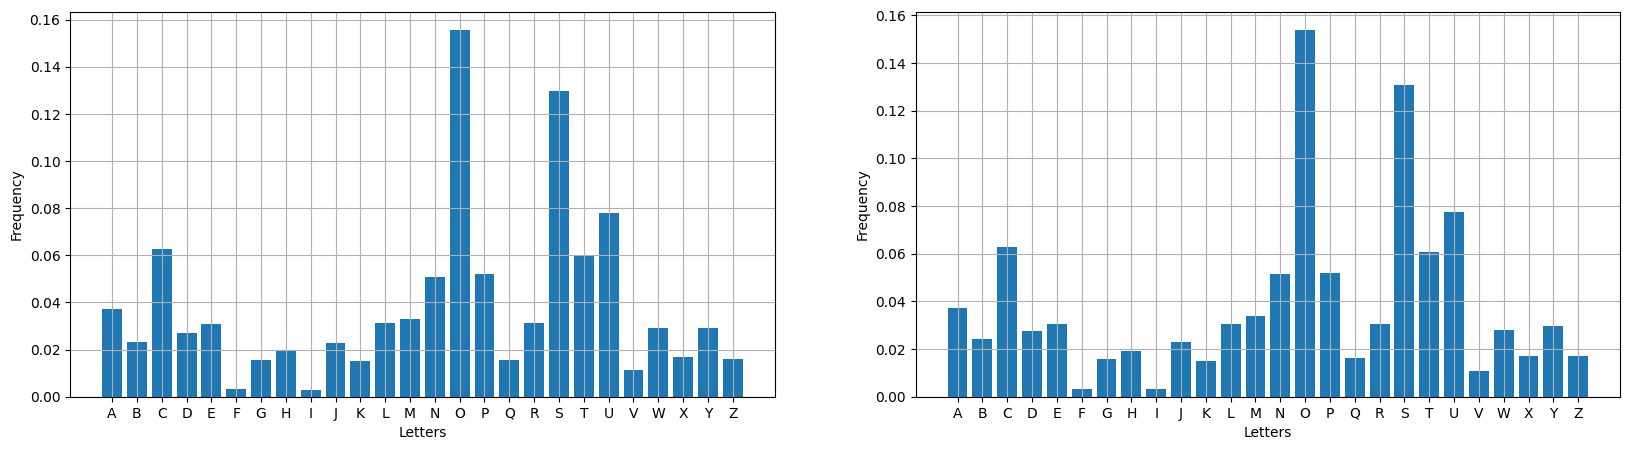

In [6]:
count_train = np.zeros(26, dtype='int')
count_test = np.zeros(26, dtype='int')
for i in np.intp(train_label):
    count_train[i] += 1
for i in np.intp(test_label):
    count_test[i] += 1

letters = np.array(list(word_dict.values()))
fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[0].bar(letters, count_train / train_label.shape[0])
ax[1].bar(letters, count_test / test_label.shape[0])
for a in ax:
    a.set(xlabel="Letters", ylabel="Frequency")
    a.grid()
plt.show()

Verifica della distribuzione delle lettere nel dataset totale

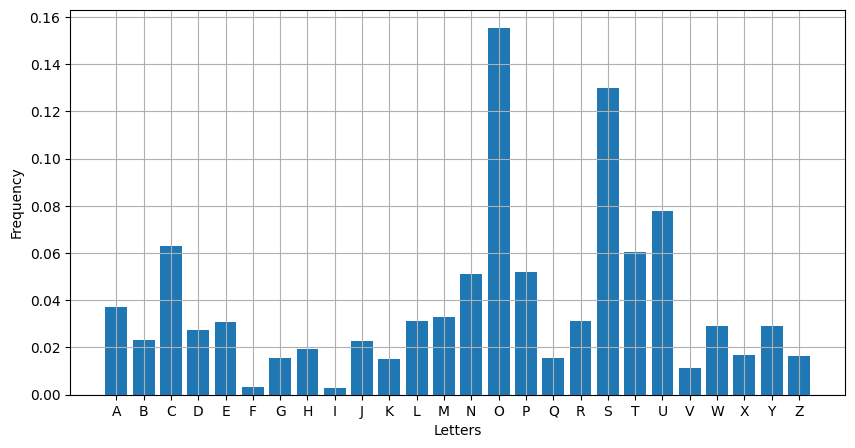

In [7]:
count_data = np.zeros(26, dtype='int')
for i in np.intp(data_label):
    count_data[i] += 1

letters = np.array(list(word_dict.values()))
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.bar(letters, count_data / data_label.shape[0])
ax.set(xlabel="Letters", ylabel="Frequency")
ax.grid()
plt.show()

## Visualizzazione di alcune lettere

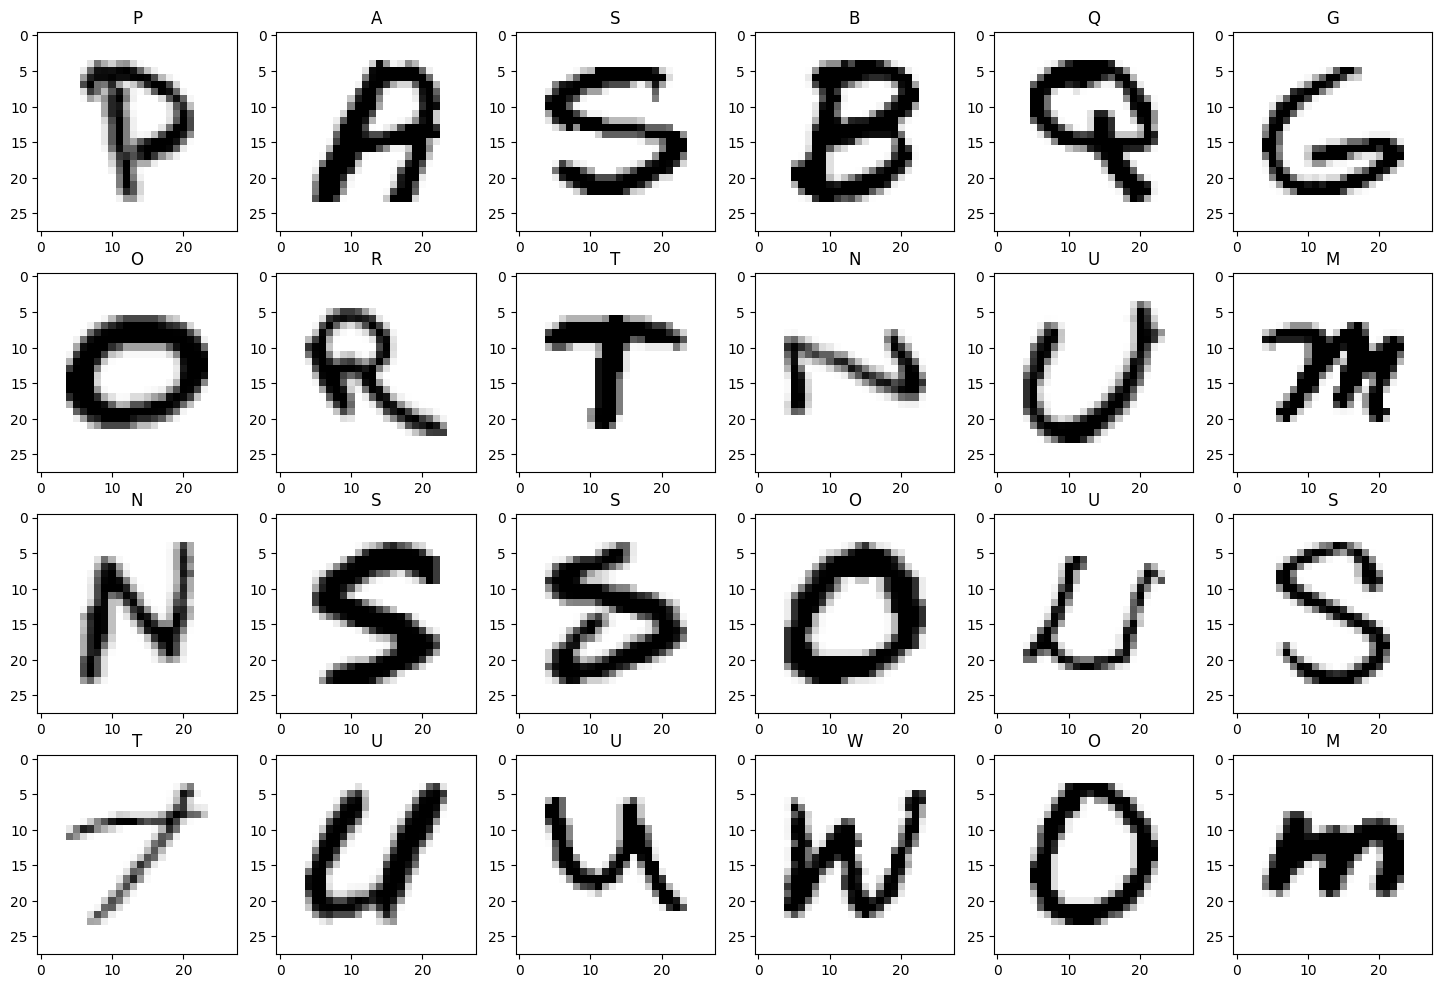

In [8]:
dim_x, dim_y = (6, 4)
fig, ax = plt.subplots(dim_y, dim_x, figsize = (3 * dim_x, 3 * dim_y))
ax = ax.flatten()
rand = np.random.default_rng()
for i in range(dim_x * dim_y):
    r = rand.integers(0, train_data.shape[0])
    ax[i].imshow(np.reshape(train_data[r], (28,28)), cmap="Greys")
    ax[i].set_title(word_dict[train_label[r]])
plt.show()

# Model training

Reshape dei dati

In [9]:
train_data = train_data.reshape(train_data.shape[0],28,28,1)
print("New shape of train data: ", train_data.shape)
test_data = test_data.reshape(test_data.shape[0], 28, 28,1)
print("New shape of train data: ", test_data.shape)
data = data.reshape(data.shape[0], 28, 28,1)

New shape of train data:  (297960, 28, 28, 1)
New shape of train data:  (74490, 28, 28, 1)


Creazione di un vettore di indice per categorie

In [10]:
train_label_OHE = np.zeros(shape=(train_label.shape[0], 26))
test_label_OHE = np.zeros(shape=(test_label.shape[0], 26))
for idx, n in enumerate(train_label):
    train_label_OHE[idx, int(n)] = 1
for idx, n in enumerate(test_label):
    test_label_OHE[idx, int(n)] = 1

Verifica GPU rilevate

In [11]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Modello con MaxPool

In [ ]:
full_maxpool_model = Sequential(name="full_maxpool")
full_maxpool_model.add(Input(shape=(28,28,1)))
full_maxpool_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', name="conv2d_1"))
full_maxpool_model.add(MaxPool2D(pool_size=(2, 2), strides=2, name="maxpool2d_1"))
full_maxpool_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same', name="conv2d_2"))
full_maxpool_model.add(MaxPool2D(pool_size=(2, 2), strides=2, name="maxpool2d_2"))
full_maxpool_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid', name="conv2d_3"))
full_maxpool_model.add(MaxPool2D(pool_size=(2, 2), strides=2, name="maxpool2d_3"))
full_maxpool_model.add(Flatten(name="flatten_1"))
full_maxpool_model.add(Dense(64,activation ="relu", name="dense_1"))
full_maxpool_model.add(Dense(128,activation ="relu", name="dense_2"))
full_maxpool_model.add(Dense(26,activation ="softmax", name="dense_3"))

full_maxpool_model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
full_maxpool_history = full_maxpool_model.fit(train_data, train_label_OHE, epochs=10,  validation_data = (test_data, test_label_OHE))

## Modello con AvgPool

In [12]:
full_avgpool_model = Sequential(name="full_avgpool")
full_avgpool_model.add(Input(shape=(28,28,1)))
full_avgpool_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', name="conv2d_1"))
full_avgpool_model.add(AvgPool2D(pool_size=(2, 2), strides=2, name="avgpool2d_1"))
full_avgpool_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same', name="conv2d_2"))
full_avgpool_model.add(AvgPool2D(pool_size=(2, 2), strides=2, name="avgpool2d_2"))
full_avgpool_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid', name="conv2d_3"))
full_avgpool_model.add(AvgPool2D(pool_size=(2, 2), strides=2, name="avgpool2d_3"))
full_avgpool_model.add(Flatten(name="flatten_1"))
full_avgpool_model.add(Dense(64,activation ="relu", name="dense_1"))
full_avgpool_model.add(Dense(128,activation ="relu", name="dense_2"))
full_avgpool_model.add(Dense(26,activation ="softmax", name="dense_3"))

full_avgpool_model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
full_avgpool_history = full_avgpool_model.fit(train_data, train_label_OHE, epochs=10,  validation_data = (test_data, test_label_OHE))

I0000 00:00:1755510389.995778      46 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5562 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:07:00.0, compute capability: 8.6
2025-08-18 09:46:41.226834: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 934402560 exceeds 10% of free system memory.
2025-08-18 09:46:44.050898: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 934402560 exceeds 10% of free system memory.


Epoch 1/10


I0000 00:00:1755510407.224599     147 service.cc:152] XLA service 0xa4f6b5c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755510407.225421     147 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-08-18 09:46:47.341978: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755510407.752173     147 cuda_dnn.cc:529] Loaded cuDNN version 90300


  44/9312 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.0630 - loss: 8.0869

I0000 00:00:1755510411.540605     147 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9312/9312 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9132 - loss: 0.3971

2025-08-18 09:47:19.352959: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 233600640 exceeds 10% of free system memory.
2025-08-18 09:47:19.617914: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 233600640 exceeds 10% of free system memory.
2025-08-18 09:47:20.338392: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_132', 4 bytes spill stores, 4 bytes spill loads

2025-08-18 09:47:25.929802: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_132', 4 bytes spill stores, 4 bytes spill loads



9312/9312 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.9133 - loss: 0.3971 - val_accuracy: 0.9825 - val_loss: 0.0615
Epoch 2/10
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.9841 - loss: 0.0568 - val_accuracy: 0.9844 - val_loss: 0.0551
Epoch 3/10
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.9882 - loss: 0.0417 - val_accuracy: 0.9871 - val_loss: 0.0478
Epoch 4/10
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.9902 - loss: 0.0344 - val_accuracy: 0.9880 - val_loss: 0.0454
Epoch 5/10
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.9915 - loss: 0.0301 - val_accuracy: 0.9891 - val_loss: 0.0436
Epoch 6/10
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.9924 - loss: 0.0277 - val_accuracy: 0.9899 - val_loss: 0.0430
Epoch 7/10
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.9925 - loss: 0.0254 - val_accuracy: 0.9902 - val_loss: 0.0388
Epoch 8/10
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.9930 - loss: 0.0246 - val

## Modello con combinazione MaxPool > AvgPool

In [25]:
maxpool_then_avgpool_model = Sequential(name="maxpool_then_avgpool")
maxpool_then_avgpool_model.add(Input(shape=(28,28,1)))
maxpool_then_avgpool_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', name="conv2d_1"))
maxpool_then_avgpool_model.add(MaxPool2D(pool_size=(2, 2), strides=2, name="maxpool2d_1"))
maxpool_then_avgpool_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same', name="conv2d_2"))
maxpool_then_avgpool_model.add(AvgPool2D(pool_size=(2, 2), strides=2, name="avgpool2d_2"))
maxpool_then_avgpool_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid', name="conv2d_3"))
maxpool_then_avgpool_model.add(AvgPool2D(pool_size=(2, 2), strides=2, name="avgpool2d_3"))
maxpool_then_avgpool_model.add(Flatten(name="flatten_1"))
maxpool_then_avgpool_model.add(Dense(64,activation ="relu", name="dense_1"))
maxpool_then_avgpool_model.add(Dense(128,activation ="relu", name="dense_2"))
maxpool_then_avgpool_model.add(Dense(26,activation ="softmax", name="dense_3"))

maxpool_then_avgpool_model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
maxpool_then_avgpool_history = maxpool_then_avgpool_model.fit(train_data, train_label_OHE, epochs=10,  validation_data = (test_data, test_label_OHE))

Epoch 1/20
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.9133 - loss: 0.4289 - val_accuracy: 0.9789 - val_loss: 0.0723
Epoch 2/20
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.9838 - loss: 0.0591 - val_accuracy: 0.9837 - val_loss: 0.0600
Epoch 3/20
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.9873 - loss: 0.0453 - val_accuracy: 0.9893 - val_loss: 0.0390
Epoch 4/20
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.9893 - loss: 0.0369 - val_accuracy: 0.9839 - val_loss: 0.0609
Epoch 5/20
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.9904 - loss: 0.0344 - val_accuracy: 0.9902 - val_loss: 0.0382
Epoch 6/20
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.9912 - loss: 0.0312 - val_accuracy: 0.9890 - val_loss: 0.0429
Epoch 7/20
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.9914 - loss: 0.0307 - val_accuracy: 0.9894 - val_loss: 0.0462
Epoch 8/20
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.9916 - loss: 0

## Modello con combinazione AvgPool > MaxPool

In [26]:
avgpool_then_maxpool_model = Sequential(name="avgpool_then_maxpool")
avgpool_then_maxpool_model.add(Input(shape=(28,28,1)))
avgpool_then_maxpool_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', name="conv2d_1"))
avgpool_then_maxpool_model.add(AvgPool2D(pool_size=(2, 2), strides=2, name="avgpool2d_1"))
avgpool_then_maxpool_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same', name="conv2d_2"))
avgpool_then_maxpool_model.add(MaxPool2D(pool_size=(2, 2), strides=2, name="maxpool2d_2"))
avgpool_then_maxpool_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid', name="conv2d_3"))
avgpool_then_maxpool_model.add(MaxPool2D(pool_size=(2, 2), strides=2, name="maxpool2d_3"))
avgpool_then_maxpool_model.add(Flatten(name="flatten_1"))
avgpool_then_maxpool_model.add(Dense(64,activation ="relu", name="dense_1"))
avgpool_then_maxpool_model.add(Dense(128,activation ="relu", name="dense_2"))
avgpool_then_maxpool_model.add(Dense(26,activation ="softmax", name="dense_3"))

avgpool_then_maxpool_model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
avgpool_then_maxpool_history = avgpool_then_maxpool_model.fit(train_data, train_label_OHE, epochs=10,  validation_data = (test_data, test_label_OHE))

Epoch 1/20
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.9051 - loss: 0.4963 - val_accuracy: 0.9776 - val_loss: 0.0813
Epoch 2/20
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.9801 - loss: 0.0704 - val_accuracy: 0.9830 - val_loss: 0.0613
Epoch 3/20
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.9841 - loss: 0.0565 - val_accuracy: 0.9841 - val_loss: 0.0601
Epoch 4/20
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.9862 - loss: 0.0503 - val_accuracy: 0.9831 - val_loss: 0.0600
Epoch 5/20
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.9877 - loss: 0.0453 - val_accuracy: 0.9876 - val_loss: 0.0484
Epoch 6/20
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.9889 - loss: 0.0432 - val_accuracy: 0.9859 - val_loss: 0.0557
Epoch 7/20
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.9890 - loss: 0.0430 - val_accuracy: 0.9886 - val_loss: 0.0482
Epoch 8/20
9312/9312 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.9900 - loss: 0

## Comparazione metodi di pool

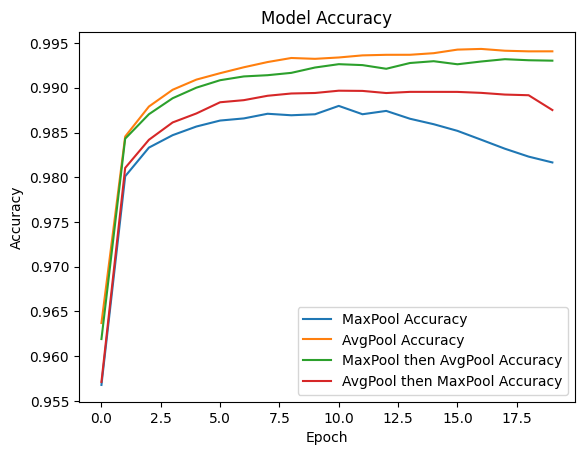

In [68]:
plt.plot(full_maxpool_history.history['accuracy'], label='MaxPool Accuracy')
plt.plot(full_avgpool_history.history['accuracy'], label='AvgPool Accuracy')
plt.plot(maxpool_then_avgpool_history.history['accuracy'], label='MaxPool then AvgPool Accuracy')
plt.plot(avgpool_then_maxpool_history.history['accuracy'], label='AvgPool then MaxPool Accuracy')

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

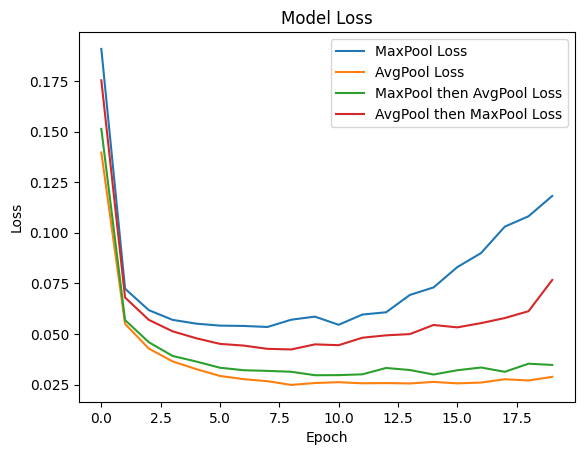

In [57]:
plt.plot(full_maxpool_history.history['loss'], label='MaxPool Loss')
plt.plot(full_avgpool_history.history['loss'], label='AvgPool Loss')
plt.plot(maxpool_then_avgpool_history.history['loss'], label='MaxPool then AvgPool Loss')
plt.plot(avgpool_then_maxpool_history.history['loss'], label='AvgPool then MaxPool Loss')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

## Scelta modello

In [16]:
model = full_maxpool_model
history = full_maxpool_history

In [15]:
model = full_avgpool_model
history = full_avgpool_history

In [ ]:
model = maxpool_then_avgpool_model
history = maxpool_then_avgpool_history

In [16]:
model = avgpool_then_maxpool_model
history = avgpool_then_maxpool_history

## Summary e salvataggio del modello

In [16]:
model.summary()
print("The validation accuracy is :", history.history['val_accuracy'])
print("The training accuracy is :", history.history['accuracy'])
print("The validation loss is :", history.history['val_loss'])
print("The training loss is :", history.history['loss'])
model.save('model_hand.keras')

Model: "full_avgpool"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avgpool2d_1 (AveragePooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avgpool2d_2 (AveragePooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avgpool2d_3 (AveragePooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,540 (1.57 MB)

 Trainable params: 137,178 (535.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 274,362 (1.05 MB)

The validation accuracy is : [0.9824808835983276, 0.9844140410423279, 0.9870989322662354, 0.9880386590957642, 0.9890589118003845, 0.9898912310600281, 0.9901597499847412, 0.9906699061393738, 0.9885756373405457, 0.9916096329689026]
The training accuracy is : [0.962541937828064, 0.9849543571472168, 0.9880285859107971, 0.989824116230011, 0.9909954071044922, 0.9919787645339966, 0.9922170639038086, 0.9927238821983337, 0.9932037591934204, 0.9931501150131226]
The validation loss is : [0.06151898577809334, 0.055147603154182434, 0.04780968651175499, 0.045432038605213165, 0.043559178709983826, 0.043014660477638245, 0.03883644938468933, 0.040239136666059494, 0.050245266407728195, 0.04024658352136612]
The training loss is : [0.14362163841724396, 0.05391184613108635, 0.04228641465306282, 0.03608396276831627, 0.03203113377094269, 0.029341572895646095, 0.026951611042022705, 0.02624266967177391, 0.024847757071256638, 0.026063747704029083]


## Prova del modello su alcuni elementi del set di test

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step

2025-08-13 11:21:35.057912: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_67', 4 bytes spill stores, 4 bytes spill loads



3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 741ms/step
5 wrong predicitons out of 81


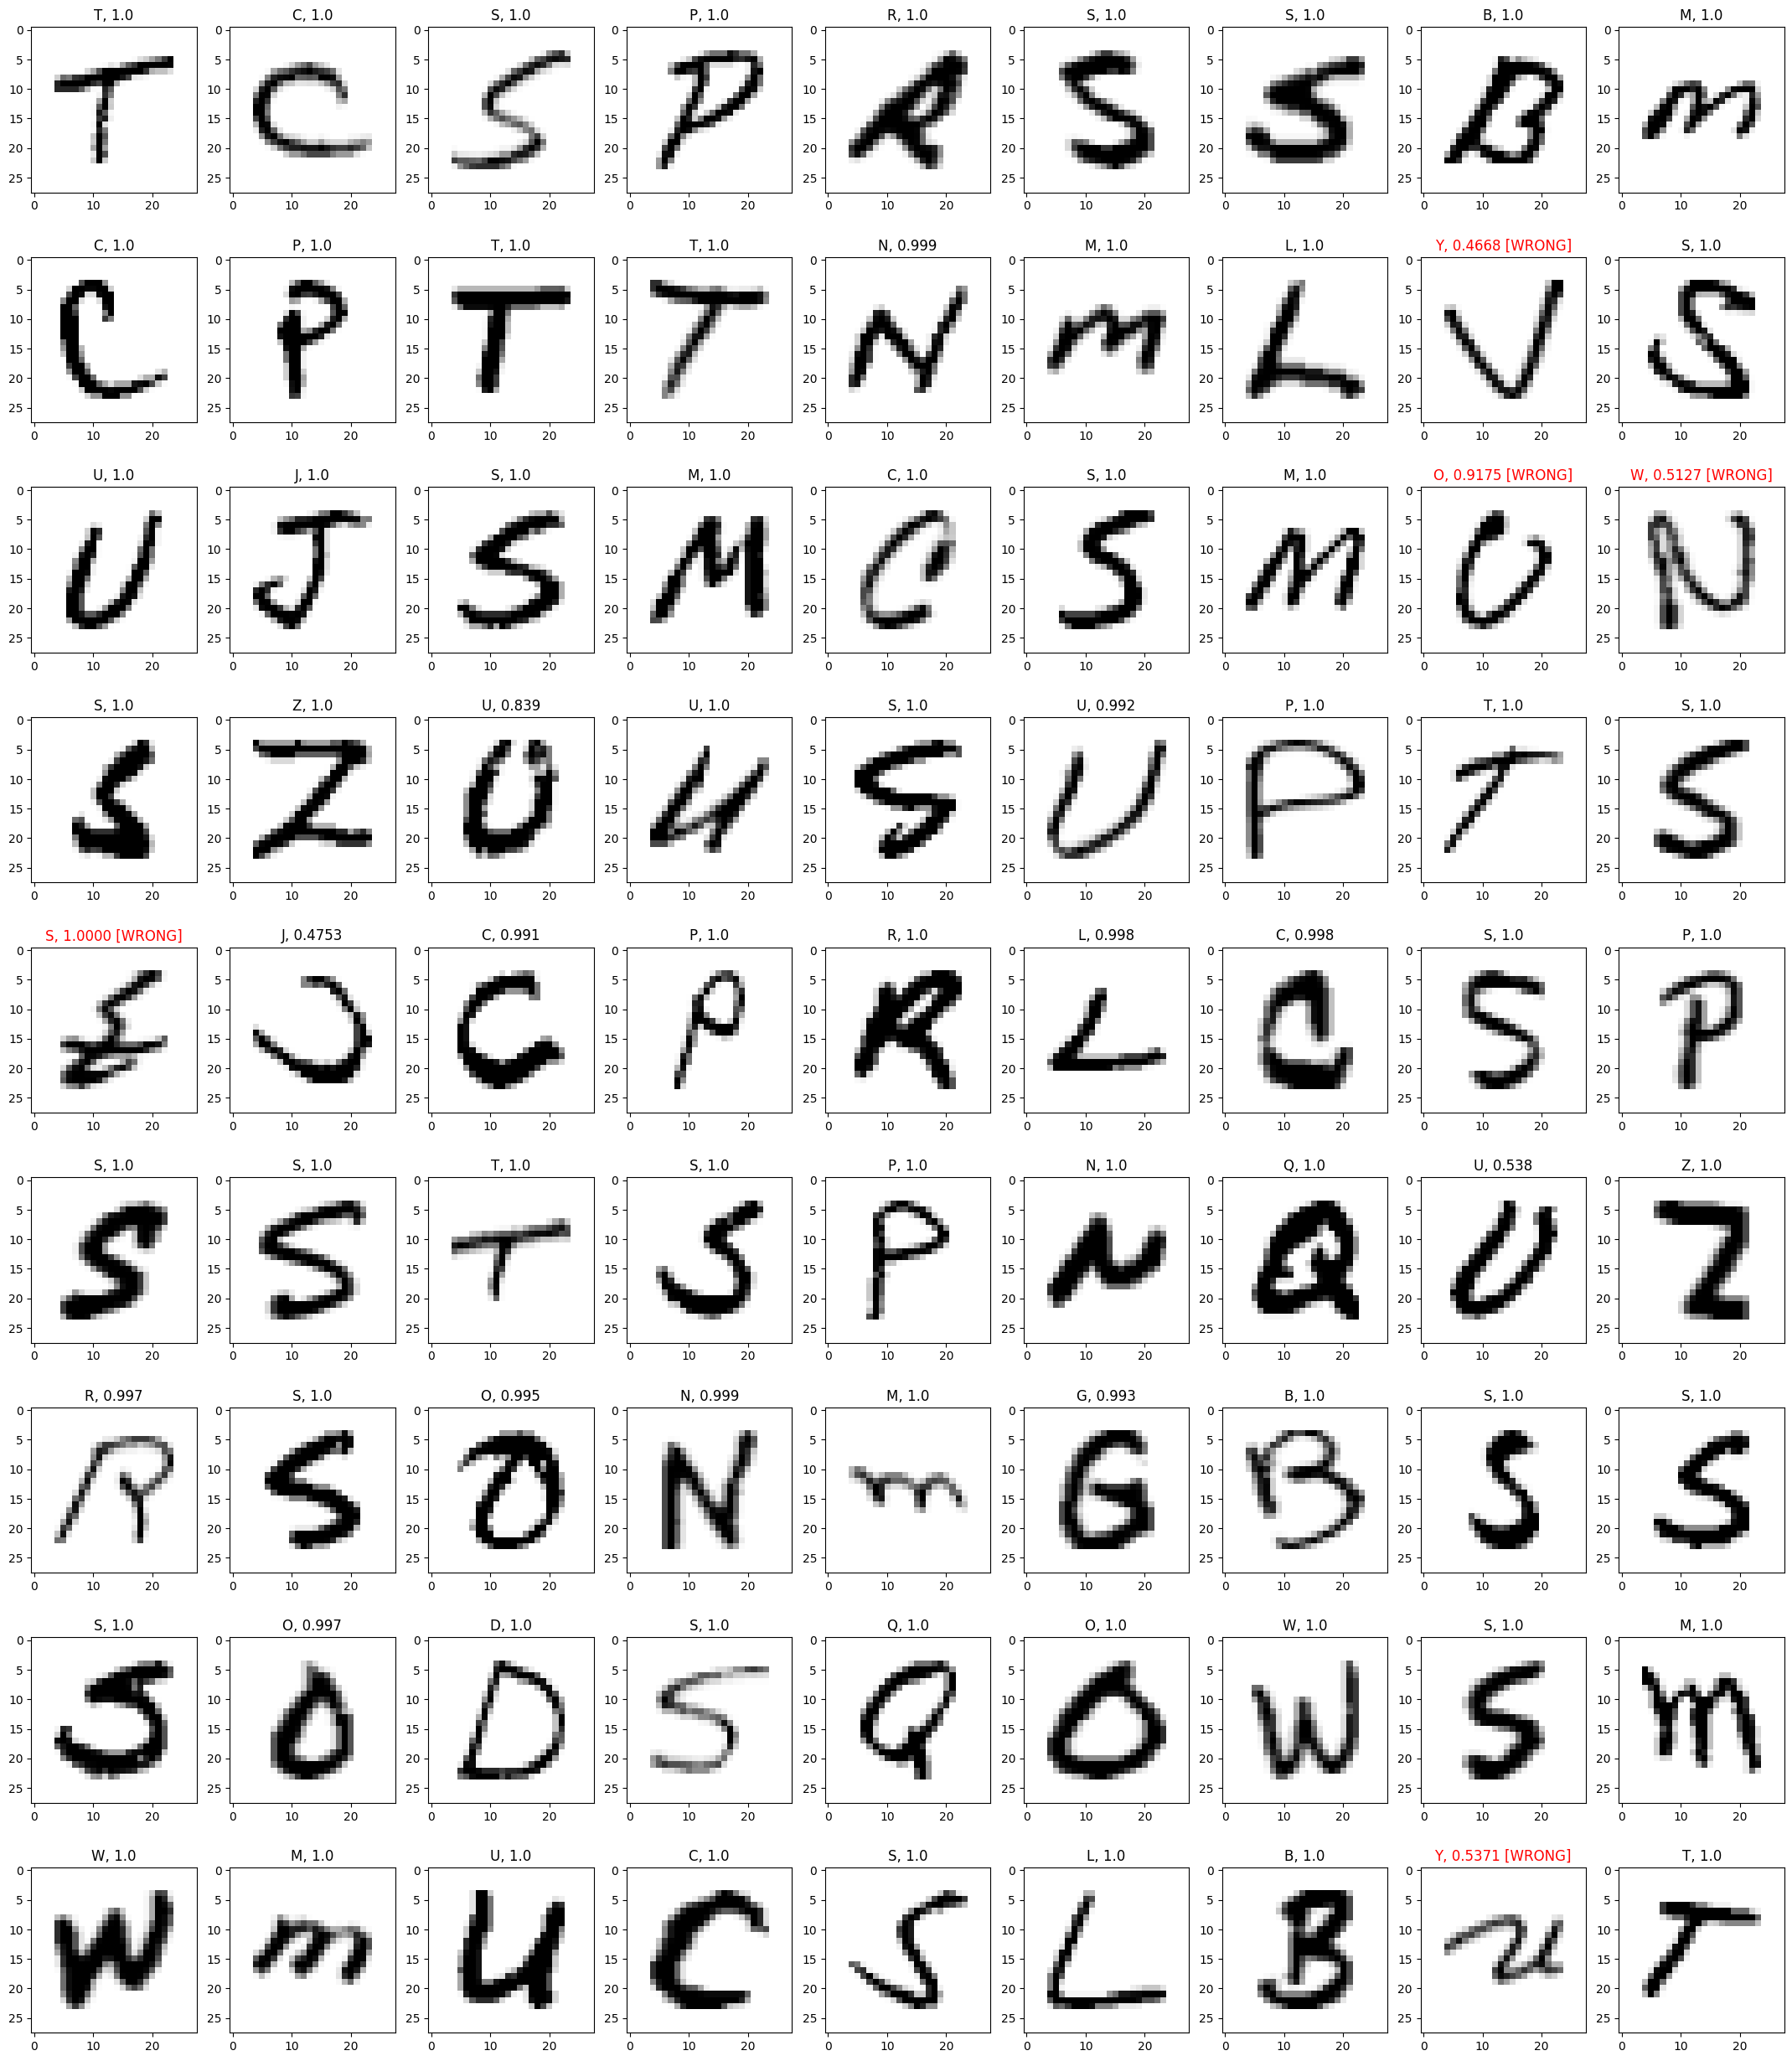

In [96]:
dim_x, dim_y = (9, 9)
wrong_index = []
pred = model.predict(test_data[:dim_x * dim_y])

fig, axes = plt.subplots(dim_y, dim_x, figsize = (3 * dim_x, 3.5 * dim_y))
axes = axes.flatten()
for i,ax in enumerate(axes):
    img = np.reshape(test_data[i], (28,28))
    ax.imshow(img, cmap="Greys")

    pred_index = np.argmax(pred[i])
    accuracy = pred[i, pred_index]
    pred_letter = word_dict[pred_index]
    title = pred_letter + ", "
    if pred_index != test_label[i]:
        wrong_index.append(test_data_index[i])
        title = title + f"{accuracy:.4f}" + " [WRONG]"
        ax.set_title(title, color='red')
    else:
        title = title + str(accuracy)
        ax.set_title(title)
    #ax.grid()

print(str(len(wrong_index)) + " wrong predicitons out of " + str(dim_x * dim_y))

## Prova del modello su tutto il set di test

In [18]:
wrong_index = []
pred = model.predict(test_data)

for i,_ in enumerate(test_data):
    pred_index = np.argmax(pred[i])
    accuracy = pred[i, pred_index]
    if pred_index != test_label[i]:
        wrong_index.append(test_data_index[i])

wrong_index_len = len(wrong_index)
test_data_len = len(test_data)
print(str(wrong_index_len) + " wrong predicitons out of " + str(test_data_len) + " (" + f"{wrong_index_len / test_data_len * 100:.5f} %):")
print(*wrong_index, sep=", ")

2328/2328 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
625 wrong predicitons out of 74490 (0.83904 %):
354846, 106311, 251701, 75810, 77868, 110477, 54788, 57604, 308095, 351963, 217733, 79251, 38550, 37806, 140898, 217365, 128981, 181335, 160501, 51249, 181361, 230171, 85571, 358368, 38676, 286523, 21059, 259777, 108195, 46969, 106703, 210192, 188828, 51021, 158781, 74997, 362385, 128112, 319609, 103567, 193984, 337407, 86555, 176160, 232794, 53944, 49027, 240250, 339246, 251075, 89900, 364103, 318529, 90256, 133812, 368626, 361374, 75482, 96977, 48417, 49954, 212719, 144504, 189979, 310520, 215526, 153659, 51913, 254369, 221925, 69684, 166997, 87966, 345827, 17554, 46590, 85437, 191664, 50966, 269528, 184116, 99077, 55868, 173684, 357996, 110522, 295984, 5872, 125719, 94071, 78303, 219748, 215256, 151265, 97503, 73512, 361460, 141914, 40093, 188620, 19422, 276629, 51618, 85266, 145609, 286669, 276518, 240527, 54697, 164335, 106209, 53600, 21741, 21601, 49860, 48562, 231042, 349608, 204077, 10458

## Prova del modello su un set critico

In [29]:
critic_data_index = [27, 48, 230, 233, 323, 457, 702, 1296, 1363, 1406, 1538, 1682, 1783, 1928, 1979, 2106, 2122, 2190, 2294, 2363, 2369, 2428, 2435, 2469, 2585, 2668, 2708, 2714, 2742, 2743, 2849, 2961, 3036, 3259, 3265, 3335, 3375, 3399, 3423, 3464, 3645, 3658, 3738, 3812, 3978, 4277, 4374, 4648, 4673, 4814, 4885, 5010, 5090, 5114, 5167, 5215, 5416, 5446, 5572, 6092, 6266, 6470, 6491, 6578, 6623, 7073, 7164, 7579, 7619, 7725, 7755, 7825, 7875, 7892, 7930, 8116, 8200, 8433, 8786, 9179, 9213, 9238, 9246, 9693, 9699, 9753, 9823, 9858, 10272, 10324, 10461, 10496, 10734, 11195, 11210, 11343, 11513, 11537, 11543, 11616, 11719, 11734, 12039, 12090, 12185, 12902, 12928, 12941, 12948, 12970, 12971, 12972, 13122, 13177, 13230, 13338, 13444, 13552, 13703, 13713, 13935, 13942, 14077, 14302, 14313, 14465, 14592, 14759, 14846, 14859, 14883, 14976, 15098, 15100, 15108, 15193, 15204, 15211, 15276, 15385, 15412, 15467, 15528, 15559, 15570, 15629, 15693, 15811, 16039, 16171, 16321, 16470, 16705, 16753, 16773, 16863, 16937, 16970, 17054, 17094, 17179, 17205, 17222, 17246, 17334, 17349, 17365, 17403, 17413, 17425, 17446, 17474, 17486, 17487, 17525, 17539, 17551, 17594, 17629, 17747, 17857, 17859, 17869, 17926, 18183, 18191, 18196, 18207, 18210, 18241, 18269, 18278, 18379, 18412, 18458, 18591, 18596, 18603, 18639, 18640, 18663, 18666, 18687, 18707, 18798, 18947, 18956, 18985, 19052, 19106, 19126, 19254, 19283, 19341, 19359, 19410, 19416, 19535, 19554, 19591, 19633, 19642, 19675, 19688, 19729, 19787, 19886, 20005, 20050, 20085, 20107, 20163, 20176, 20242, 20265, 20419, 20476, 20590, 20592, 20707, 20775, 20779, 20893, 20969, 20977, 21099, 21126, 21176, 21232, 21316, 21371, 21416, 21437, 21472, 21483, 21514, 21587, 21614, 21664, 21679, 21733, 21793, 21814, 21832, 21858, 21861, 21923, 22009, 22092, 22199, 22331, 22339, 22345, 22472, 22602, 22653, 22742, 22844, 23256, 23373, 23488, 23491, 23494, 23909, 24046, 24146, 24238, 24350, 24931, 24983, 25005, 25369, 25583, 25621, 25711, 25924, 26053, 26068, 26260, 26554, 26670, 26769, 26885, 27040, 27231, 27315, 27323, 27338, 27444, 27494, 27799, 27916, 27999, 28075, 28133, 28150, 28190, 28277, 28351, 28361, 28381, 28450, 28473, 28484, 28496, 28497, 28506, 28514, 28552, 28596, 28633, 28641, 28652, 28675, 28706, 28791, 28831, 28866, 28884, 28911, 28925, 28927, 28935, 28942, 28959, 28980, 29047, 29177, 29265, 29306, 29319, 29320, 29503, 29519, 29573, 29731, 29815, 29953, 29967, 30068, 30257, 30285, 30293, 30327, 30442, 30534, 30584, 30659, 30731, 30735, 30737, 30855, 30867, 31052, 31113, 31150, 31197, 31206, 31211, 31222, 31318, 31348, 31513, 31648, 31715, 31744, 31838, 32020, 32071, 32112, 32145, 32202, 32239, 32249, 32340, 32353, 32476, 32579, 32593, 32612, 32671, 32772, 32777, 32949, 32994, 33106, 33119, 33141, 33151, 33388, 33464, 33493, 33674, 34370, 34503, 34775, 34883, 35287, 35603, 35697, 36012, 36031, 36372, 36613, 37552, 37629, 37663, 37717, 37787, 37788, 37809, 37917, 37931, 37998, 38016, 38018, 38091, 38144, 38165, 38180, 38209, 38210, 38231, 38257, 38290, 38307, 38350, 38359, 38362, 38368, 38382, 38398, 38405, 38550, 38560, 38655, 38684, 38727, 38753, 38774, 38907, 38919, 38930, 39267, 39269, 39299, 39338, 39561, 39605, 39659, 39733, 39973, 40035, 40046, 40065, 40093, 40424, 40443, 40476, 40607, 40648, 40683, 40700, 40719, 40723, 40769, 40846, 40848, 40863, 40877, 40894, 40933, 41038, 41069, 41156, 41200, 41206, 41228, 41272, 41318, 41386, 41401, 41456, 41465, 41488, 41613, 41695, 41699, 41703, 41725, 41727, 41744, 41766, 41864, 41917, 42159, 42226, 42235, 42700, 42754, 42928, 43077, 43125, 43350, 43609, 43736, 43856, 44059, 44087, 44089, 44157, 44182, 44183, 44202, 44308, 44320, 44334, 44360, 44364, 44416, 44457, 44478, 44489, 44597, 44649, 45109, 45178, 45263, 45449, 45678, 45920, 45945, 45950, 45977, 46002, 46123, 46143, 46187, 46204, 46232, 46246, 46247, 46291, 46378, 46509, 46530, 46644, 46687, 46734, 46805, 46806, 46822, 46892, 46943, 46983, 47030, 47035, 47036, 47041, 47058, 47063, 47064, 47144, 47182, 47197, 47241, 47248, 47261, 47379, 47394, 47437, 47463, 47467, 47478, 47517, 47710, 47719, 47769, 47785, 47810, 48007, 48100, 48102, 48286, 48355, 48422, 48427, 48448, 48462, 48465, 48472, 48474, 48505, 48560, 48637, 48749, 48751, 48769, 48899, 48908, 48909, 48981, 49025, 49027, 49030, 49166, 49193, 49231, 49260, 49289, 49385, 49390, 49397, 49448, 49542, 49552, 49618, 49630, 49668, 49727, 49740, 49783, 49786, 49787, 49804, 49845, 49850, 49855, 49913, 49914, 50008, 50010, 50018, 50086, 50091, 50122, 50136, 50149, 50207, 50221, 50241, 50348, 50361, 50412, 50489, 50513, 50603, 50604, 50645, 50649, 50774, 50830, 50966, 50976, 50979, 51027, 51033, 51056, 51079, 51093, 51103, 51132, 51152, 51188, 51194, 51274, 51319, 51342, 51361, 51383, 51395, 51412, 51413, 51419, 51474, 51479, 51481, 51495, 51528, 51555, 51617, 51628, 51643, 51679, 51718, 51719, 51745, 51762, 51764, 51786, 51794, 51812, 51876, 51877, 51901, 51909, 51935, 52010, 52068, 52096, 52113, 52133, 52140, 52144, 52175, 52180, 52198, 52211, 52241, 52242, 52263, 52278, 52283, 52312, 52314, 52318, 52341, 52365, 52402, 52457, 52530, 52610, 52677, 52701, 52748, 52803, 52807, 52820, 52857, 52887, 52890, 52938, 52950, 52977, 52987, 53032, 53041, 53043, 53070, 53076, 53155, 53214, 53240, 53267, 53276, 53298, 53318, 53323, 53384, 53423, 53447, 53480, 53481, 53498, 53557, 53574, 53582, 53602, 53646, 53685, 53695, 53756, 53814, 53895, 53944, 53974, 54004, 54085, 54106, 54118, 54126, 54156, 54253, 54291, 54329, 54335, 54409, 54416, 54444, 54527, 54623, 54653, 54697, 54733, 54749, 54751, 54802, 54811, 54865, 54896, 54917, 54931, 54942, 54943, 54975, 54982, 54998, 55042, 55137, 55138, 55140, 55180, 55228, 55240, 55257, 55309, 55399, 55495, 55518, 55548, 55628, 55663, 55714, 55731, 55761, 55787, 55832, 55844, 55893, 55909, 56022, 56031, 56050, 56058, 56076, 56077, 56080, 56160, 56169, 56336, 56394, 56417, 56565, 56683, 56998, 57145, 57453, 57604, 57672, 57699, 57789, 57967, 58008, 58040, 58075, 58293, 58314, 58503, 58583, 58592, 58608, 58630, 58700, 58706, 58870, 58965, 59070, 59125, 59150, 59245, 59393, 59425, 59436, 59489, 59629, 59665, 59740, 59886, 59922, 59996, 60026, 60040, 60044, 60046, 60065, 60148, 60210, 60396, 60492, 60757, 60873, 60890, 60965, 60990, 61003, 61286, 61443, 61470, 61532, 61813, 61867, 61936, 62066, 62196, 62473, 62794, 62832, 62851, 63021, 63044, 63149, 63180, 63239, 63403, 63459, 63770, 63991, 64071, 64206, 64579, 64610, 64913, 65042, 65107, 65117, 65123, 65231, 65414, 65579, 65604, 65663, 65693, 65707, 65935, 65994, 66016, 66066, 66178, 66224, 66280, 66392, 66402, 66492, 66505, 66840, 66868, 66940, 66947, 66967, 66988, 67095, 67133, 67163, 67164, 67232, 67274, 67313, 67324, 67444, 67493, 67527, 67565, 67596, 67674, 67774, 67806, 67859, 67861, 67922, 67923, 67946, 67964, 68013, 68077, 68108, 68174, 68190, 68359, 68384, 68467, 68471, 68635, 68656, 68670, 68671, 68691, 68714, 68781, 68879, 68881, 68890, 68899, 68958, 68978, 68989, 69018, 69021, 69034, 69065, 69068, 69091, 69128, 69214, 69240, 69250, 69284, 69308, 69346, 69361, 69405, 69421, 69464, 69479, 69511, 69540, 69543, 69566, 69668, 69671, 69725, 69876, 69930, 69963, 69974, 70018, 70032, 70052, 70062, 70068, 70097, 70185, 70204, 70265, 70329, 70362, 70382, 70405, 70436, 70447, 70452, 70470, 70490, 70496, 70513, 70558, 70599, 70638, 70656, 70714, 70721, 70750, 70766, 70833, 70903, 70921, 70942, 70961, 70972, 70981, 70996, 71016, 71081, 71085, 71127, 71140, 71144, 71180, 71231, 71239, 71340, 71363, 71377, 71382, 71406, 71455, 71473, 71489, 71500, 71537, 71596, 71645, 71706, 71708, 71721, 71790, 71799, 71817, 71847, 71903, 71969, 71981, 72120, 72128, 72143, 72162, 72164, 72194, 72212, 72216, 72268, 72333, 72428, 72516, 72544, 72554, 72555, 72572, 72592, 72618, 72631, 72668, 72669, 72744, 72751, 72781, 72820, 72842, 72878, 72881, 72912, 72922, 73062, 73121, 73130, 73139, 73156, 73175, 73176, 73238, 73243, 73267, 73301, 73319, 73356, 73381, 73385, 73470, 73560, 73561, 73704, 73726, 73764, 73783, 73862, 73929, 73931, 73946, 73974, 73996, 74019, 74029, 74075, 74078, 74112, 74124, 74133, 74178, 74246, 74287, 74297, 74325, 74395, 74397, 74412, 74433, 74439, 74448, 74449, 74464, 74546, 74578, 74908, 74909, 75557, 75669, 75676, 75714, 75781, 75802, 75876, 75915, 75930, 75937, 76059, 76340, 76462, 76514, 76517, 76539, 76644, 76661, 76954, 76967, 77003, 77017, 77044, 77061, 77068, 77070, 77112, 77122, 77142, 77151, 77209, 77215, 77235, 77238, 77255, 77286, 77295, 77300, 77311, 77398, 77415, 77417, 77457, 77471, 77485, 77501, 77624, 77713, 77739, 77758, 77824, 77880, 77888, 77894, 77898, 78002, 78013, 78048, 78050, 78107, 78147, 78160, 78178, 78206, 78211, 78298, 78302, 78304, 78404, 78451, 78458, 78463, 78477, 78490, 78500, 78570, 78780, 79037, 79098, 79148, 79186, 79232, 79265, 79352, 79372, 79419, 79461, 79524, 79564, 79604, 79618, 79689, 79794, 79824, 79950, 79952, 80079, 80215, 80231, 80310, 80540, 80596, 80631, 80639, 80949, 81031, 81162, 81187, 81197, 81200, 81244, 81264, 81296, 81308, 81342, 81414, 81493, 81733, 81762, 81795, 81885, 81918, 81997, 82014, 82019, 82023, 82144, 82157, 82174, 82281, 82291, 82315, 82394, 82401, 82427, 82606, 82630, 82639, 82799, 82849, 82919, 82928, 82935, 82944, 82946, 82988, 82997, 83037, 83050, 83156, 83277, 83335, 83387, 83560, 83612, 83616, 83621, 83622, 83676, 83728, 83763, 83798, 83828, 83880, 83897, 83906, 83954, 84019, 84042, 84053, 84064, 84122, 84137, 84160, 84268, 84275, 84330, 84395, 84420, 84424, 84441, 84498, 84503, 84558, 84561, 84602, 84614, 84639, 84653, 84661, 84697, 84717, 84720, 84799, 84824, 84854, 84868, 84895, 84955, 84987, 84996, 85027, 85059, 85066, 85081, 85119, 85125, 85136, 85249, 85334, 85354, 85382, 85394, 85422, 85435, 85448, 85492, 85506, 85509, 85531, 85552, 85570, 85763, 85815, 85841, 85856, 85876, 85890, 85891, 85912, 85926, 85965, 86009, 86013, 86036, 86040, 86101, 86129, 86132, 86149, 86153, 86211, 86212, 86217, 86219, 86237, 86245, 86246, 86274, 86278, 86281, 86320, 86327, 86402, 86405, 86409, 86410, 86430, 86494, 86497, 86525, 86535, 86564, 86595, 86601, 86602, 86603, 86609, 86614, 86626, 86635, 86684, 86699, 86700, 86726, 86735, 86755, 86804, 86834, 86883, 86889, 86901, 86947, 86985, 87048, 87075, 87117, 87144, 87223, 87224, 87232, 87249, 87270, 87335, 87360, 87413, 87417, 87423, 87431, 87472, 87500, 87545, 87566, 87568, 87581, 87615, 87685, 87735, 87778, 87780, 87840, 87870, 87914, 87945, 88005, 88038, 88042, 88056, 88174, 88214, 88217, 88231, 88240, 88254, 88303, 88330, 88351, 88355, 88365, 88394, 88404, 88435, 88527, 88613, 88620, 88722, 88735, 88774, 88799, 88824, 88832, 88854, 88870, 88880, 88881, 88908, 88917, 88935, 89004, 89052, 89095, 89102, 89121, 89135, 89150, 89159, 89196, 89267, 89288, 89328, 89379, 89436, 89440, 89442, 89451, 89455, 89503, 89565, 89679, 89728, 89737, 89771, 89773, 89790, 89834, 89836, 89859, 89861, 89884, 89936, 89950, 90015, 90024, 90066, 90102, 90135, 90169, 90181, 90192, 90208, 90245, 90287, 90306, 90330, 90339, 90409, 90429, 90440, 90471, 90549, 90630, 90635, 90655, 90715, 90726, 90728, 90767, 90796, 90826, 90872, 90888, 90917, 90919, 90950, 91043, 91061, 91071, 91099, 91103, 91122, 91141, 91143, 91151, 91160, 91214, 91237, 91239, 91244, 91256, 91512, 91521, 91546, 91596, 91673, 91676, 91773, 91808, 91822, 91943, 91944, 91965, 92076, 92106, 92273, 92314, 92921, 93009, 93020, 93063, 93090, 93096, 93161, 93188, 93203, 93282, 93303, 93340, 93420, 93502, 93606, 93621, 93637, 93655, 93706, 93724, 93825, 93883, 93978, 94089, 94183, 94268, 94279, 94306, 94327, 94342, 94391, 94528, 94551, 94585, 94604, 94666, 94729, 94781, 94819, 94860, 94904, 94944, 95009, 95010, 95078, 95161, 95290, 95467, 95528, 95717, 95787, 95871, 95894, 95915, 95918, 95997, 95999, 96409, 96421, 96477, 96505, 96514, 96578, 96679, 96693, 96859, 96863, 96977, 97339, 97631, 97744, 97755, 97833, 98030, 98094, 98140, 98244, 98577, 98799, 98857, 99026, 99068, 99077, 99161, 99368, 99435, 99705, 99813, 100060, 100071, 100240, 100369, 100422, 100504, 100661, 100762, 100888, 101063, 101428, 101448, 101690, 102457, 103002, 103039, 103046, 103054, 103294, 103414, 103488, 103527, 103544, 103648, 103654, 103829, 103939, 104137, 104203, 104260, 104403, 104436, 104441, 104565, 104636, 104662, 104692, 104799, 104845, 104909, 105097, 105232, 105268, 105376, 105467, 105536, 105727, 105737, 105870, 105875, 105987, 105992, 106209, 106276, 106403, 106411, 106429, 106452, 106478, 106480, 106532, 106589, 106682, 106939, 107049, 107289, 107335, 107443, 107477, 107490, 107509, 107536, 107538, 107543, 107569, 107653, 107764, 107765, 107819, 107922, 108067, 108211, 108373, 108457, 108466, 108678, 108731, 108897, 108901, 108915, 108980, 109073, 109224, 109227, 109524, 109579, 109600, 109642, 109673, 109821, 109839, 109888, 109915, 110248, 110266, 110271, 110277, 110287, 110361, 110395, 110400, 110404, 110417, 110422, 110426, 110511, 110546, 110577, 110604, 110610, 110627, 110628, 110636, 110668, 110676, 110726, 110734, 110774, 110809, 110820, 110830, 110832, 110844, 110863, 110945, 111025, 111059, 111063, 111064, 111067, 111080, 111205, 111266, 111306, 111309, 111325, 111341, 111351, 111386, 111444, 111446, 111460, 111479, 111564, 111606, 111615, 111666, 111680, 111688, 111724, 111746, 111949, 111955, 112023, 112145, 112166, 112185, 112209, 112264, 112302, 112345, 112554, 112587, 112597, 112624, 112667, 112748, 112885, 112927, 112930, 113051, 113113, 113202, 113247, 113265, 113277, 113498, 113522, 113692, 113704, 113774, 113776, 113778, 113811, 113822, 113823, 113827, 113843, 114064, 114126, 114158, 114180, 114240, 114269, 114270, 114294, 114369, 114405, 114413, 114450, 114473, 114531, 114594, 114767, 114822, 114897, 114910, 115076, 115167, 115215, 115240, 115306, 115657, 115737, 115738, 115753, 115782, 115791, 115793, 115859, 115873, 115923, 115955, 115996, 116000, 116011, 116012, 116053, 116109, 116227, 116250, 116334, 116429, 116443, 116493, 116541, 116675, 116710, 116776, 116824, 116845, 116848, 116854, 116860, 116950, 116977, 117052, 117139, 117215, 117235, 117260, 117281, 117282, 117314, 117315, 117338, 117420, 117470, 117497, 117798, 117828, 117973, 118067, 118219, 118310, 118364, 118413, 118497, 118611, 118624, 118661, 118688, 118975, 119078, 119117, 119176, 119237, 119281, 119363, 119402, 119449, 119477, 119530, 119538, 119631, 119735, 119791, 119973, 119981, 119997, 120266, 120344, 120537, 120588, 120752, 120795, 120814, 120879, 120920, 120921, 120979, 121088, 121096, 121101, 121106, 121334, 121378, 121413, 121838, 121918, 122233, 122477, 122500, 122581, 122721, 122928, 122971, 123036, 123133, 123140, 123142, 123280, 123292, 123341, 123410, 123775, 123809, 123824, 123830, 123839, 123908, 123912, 124047, 124165, 124180, 124212, 124403, 124459, 124659, 124688, 124693, 124721, 124724, 124731, 124734, 125242, 125271, 125304, 125564, 125589, 125678, 125712, 126225, 126235, 126246, 126335, 126363, 126649, 126815, 126831, 126903, 127378, 127550, 127605, 127634, 127653, 127699, 127702, 127874, 128102, 128169, 128170, 128196, 128214, 128222, 128292, 128981, 129097, 129119, 129167, 129223, 129261, 129380, 129492, 129508, 129677, 129961, 130015, 130016, 130106, 130380, 130424, 130433, 130471, 130632, 130798, 130965, 131006, 131030, 131135, 131148, 131411, 131420, 131549, 131592, 131710, 131868, 131881, 131974, 131984, 132159, 132277, 132375, 132461, 132518, 132621, 132687, 132755, 132762, 133380, 133384, 133761, 133786, 133812, 133813, 133826, 133868, 133901, 134087, 134119, 134424, 134441, 134630, 134703, 134731, 134736, 134740, 134766, 134783, 135030, 135239, 135347, 135380, 135527, 135559, 135911, 136291, 136337, 136367, 136379, 136491, 136676, 136725, 136774, 136830, 136949, 137282, 137384, 137480, 137591, 137697, 137771, 137833, 138044, 138144, 138154, 138244, 138258, 138267, 138300, 138314, 138321, 138488, 138593, 138797, 138998, 139077, 139129, 139251, 139327, 139345, 139520, 139533, 139628, 139683, 139720, 139796, 140212, 140279, 140412, 140422, 140444, 140558, 140560, 140793, 140841, 141273, 141914, 143393, 143992, 144460, 144899, 145497, 145558, 146097, 146491, 146648, 147018, 147029, 148224, 148723, 149331, 150202, 150278, 150549, 150551, 150571, 150878, 151007, 151014, 151087, 151141, 151211, 151413, 151700, 151784, 151959, 152034, 152063, 152542, 152618, 152648, 153209, 153435, 153578, 153644, 153789, 154024, 154096, 154256, 154434, 154585, 155488, 156058, 156138, 156144, 156817, 157718, 157788, 157878, 157901, 158099, 158405, 158472, 158507, 159065, 159175, 159205, 160573, 160811, 160974, 161096, 161108, 161109, 161177, 161674, 161676, 162746, 162772, 162989, 163052, 163250, 163419, 163668, 163816, 164402, 164515, 164521, 164767, 164898, 165261, 165265, 165505, 165839, 165873, 166343, 166344, 167112, 167116, 167604, 167802, 168205, 168365, 168596, 168675, 168937, 169011, 169734, 169813, 170363, 170391, 170468, 170871, 170887, 170903, 170906, 170936, 171197, 171206, 171599, 171695, 171937, 171955, 172291, 172304, 172318, 172509, 172521, 172838, 173918, 174047, 174216, 174369, 174527, 174834, 175707, 175949, 176121, 176404, 177229, 177251, 177609, 177628, 177735, 179509, 179776, 179952, 180652, 180722, 180979, 181293, 182005, 182160, 182283, 182642, 184791, 185968, 185986, 186530, 186645, 186649, 186941, 186964, 187052, 187088, 187264, 187450, 187642, 187823, 188347, 188390, 188399, 188686, 188726, 188845, 188928, 189021, 189225, 189317, 189405, 190074, 190094, 190104, 190667, 190669, 190815, 191038, 191798, 191863, 192644, 192650, 192793, 192892, 193059, 193269, 193279, 193372, 193479, 193847, 194073, 194365, 194575, 194781, 194858, 195036, 195993, 196399, 196529, 197495, 197570, 197758, 197898, 197983, 197992, 198186, 198219, 198406, 198538, 198631, 198786, 198807, 198809, 198811, 199003, 199159, 199280, 199702, 199813, 199856, 199952, 199954, 199986, 200166, 200173, 200217, 200296, 200360, 200399, 200417, 200419, 200524, 200646, 200723, 200898, 201053, 201311, 201360, 201469, 201873, 202001, 202027, 202184, 202269, 202352, 202443, 202641, 203491, 203761, 203913, 203926, 204013, 204108, 204112, 204451, 204718, 204798, 205319, 205384, 205402, 205709, 205738, 205759, 205844, 205847, 205902, 205997, 206042, 206091, 206111, 206188, 206370, 206383, 206423, 206509, 206520, 206681, 206704, 206732, 206853, 206856, 206903, 206998, 207049, 207139, 207225, 207405, 207804, 208035, 208097, 208207, 208309, 208321, 208554, 208627, 208703, 208778, 208781, 209236, 209464, 209634, 209702, 209738, 209860, 209875, 210094, 210162, 210191, 210213, 210304, 210350, 210351, 210407, 210508, 210641, 210727, 211143, 211255, 211293, 211722, 211736, 211820, 211895, 211947, 212331, 212552, 212615, 212688, 212739, 212781, 212978, 213072, 213160, 213284, 213330, 213479, 213952, 214132, 214688, 214938, 215016, 215127, 215276, 215289, 215334, 215502, 215533, 215599, 216032, 216124, 216161, 216318, 216350, 216372, 216438, 216744, 216770, 216965, 217018, 217031, 217040, 217045, 217056, 217109, 217262, 217285, 217324, 217357, 217411, 217485, 217527, 217584, 217629, 217636, 217776, 217787, 217847, 217854, 217880, 217924, 217964, 218074, 218075, 218096, 218101, 218163, 218386, 218421, 218472, 218502, 218516, 218566, 218612, 218669, 218736, 218845, 218918, 219014, 219024, 219052, 219074, 219102, 219121, 219159, 219216, 219245, 219255, 219281, 219288, 219371, 219398, 219541, 219555, 219559, 219568, 219578, 219719, 219775, 219822, 219835, 219852, 219859, 219873, 219904, 219954, 220033, 220084, 220121, 220129, 220207, 220300, 220342, 220352, 220492, 220522, 220530, 220682, 220708, 220757, 220777, 220793, 220905, 220912, 220922, 220929, 221002, 221040, 221046, 221080, 221104, 221120, 221150, 221195, 221225, 221232, 221235, 221251, 221262, 221305, 221405, 221511, 221640, 221674, 221691, 221726, 221837, 222065, 222091, 222146, 222174, 222244, 222312, 222393, 222434, 222513, 222635, 222644, 222663, 222664, 222680, 222734, 222763, 222778, 222798, 222801, 222803, 222813, 222895, 222996, 223111, 223262, 223266, 223275, 223316, 223540, 223550, 223571, 223744, 223849, 223887, 223898, 223954, 224303, 224571, 224780, 224786, 225043, 225116, 225155, 225225, 225281, 225293, 225378, 225386, 225453, 225475, 225486, 225499, 225570, 225609, 225625, 225952, 225963, 226050, 226260, 226399, 226401, 226542, 226551, 226661, 226719, 226793, 226947, 227177, 227469, 227584, 227615, 227887, 227905, 228091, 228292, 228398, 228462, 228614, 228657, 228715, 228724, 228813, 229159, 229368, 229377, 229502, 229597, 229764, 229805, 229856, 229998, 230007, 230154, 230220, 230574, 230595, 231042, 231044, 231169, 231324, 231461, 231462, 231592, 231630, 231701, 231847, 232217, 232438, 232449, 232504, 232523, 232651, 232657, 232758, 232785, 232861, 233291, 233331, 233503, 233592, 234350, 234631, 234715, 235065, 235087, 235119, 235630, 236237, 237629, 237998, 238492, 238566, 239106, 239306, 239486, 239953, 240278, 240478, 240523, 240610, 240650, 240721, 241268, 241663, 241708, 241777, 241849, 242320, 242458, 242585, 242719, 242806, 242855, 243059, 243060, 243229, 243444, 243863, 243907, 243998, 244195, 244204, 244728, 244880, 245058, 245571, 245889, 246779, 246870, 246936, 248637, 248756, 248965, 248971, 249329, 249884, 249895, 249896, 250024, 250095, 250367, 250489, 250551, 250681, 250745, 251456, 252418, 253162, 253365, 253378, 253721, 253818, 253972, 254468, 254515, 254717, 255141, 255339, 255486, 255923, 255937, 256384, 256618, 256653, 256870, 256871, 256943, 257021, 257143, 257658, 257913, 257974, 259192, 259408, 259529, 259777, 260258, 260913, 261044, 261124, 261185, 261763, 263057, 263967, 264627, 267644, 268432, 268966, 269465, 269672, 269804, 270646, 271450, 272409, 272841, 273333, 273335, 273462, 273759, 273927, 273990, 274296, 274829, 274864, 275034, 275523, 275854, 276297, 277274, 277310, 277630, 279395, 279521, 279555, 279662, 280124, 280240, 281534, 282116, 282789, 282793, 282795, 283568, 283677, 283678, 283833, 283994, 284796, 284879, 285206, 285283, 285413, 285683, 286035, 286238, 286269, 286285, 286302, 286344, 286393, 286432, 286466, 286527, 286572, 286801, 286836, 287005, 287072, 287176, 287674, 288471, 288848, 289313, 289395, 289588, 289637, 289672, 289720, 290601, 290603, 290606, 290743, 290784, 290819, 290851, 290894, 290896, 290951, 290985, 290990, 291060, 291090, 291123, 291134, 291207, 291386, 291449, 291498, 292005, 292059, 292359, 292804, 293299, 293304, 293305, 293380, 294187, 294298, 294422, 294457, 294583, 295171, 295429, 295514, 295899, 296129, 296390, 296574, 296914, 296932, 297033, 297436, 297770, 297957, 297960, 297961, 298382, 298462, 298787, 298892, 299224, 299231, 299718, 299771, 299948, 300152, 300460, 300618, 300687, 300704, 300871, 300932, 300980, 300990, 301187, 301488, 301490, 301653, 301903, 302166, 302294, 302345, 302398, 302459, 302462, 302533, 302709, 302710, 302754, 302757, 302809, 302833, 302980, 303191, 303210, 303218, 303357, 303456, 303497, 303538, 303551, 303854, 303856, 304210, 304578, 304925, 305162, 305165, 305371, 305774, 305912, 306001, 306224, 306352, 306375, 306392, 306851, 306853, 306969, 307005, 307007, 307435, 307442, 307636, 307715, 307729, 307865, 307902, 308268, 308389, 308507, 308508, 308607, 308621, 308627, 308643, 308834, 308866, 308924, 308926, 309074, 309098, 309103, 309136, 309462, 309599, 309760, 309887, 309902, 310018, 310099, 310231, 310269, 310310, 310385, 310593, 310618, 310637, 310698, 311130, 311166, 311222, 311243, 311366, 311617, 311725, 311806, 311813, 311817, 311986, 312008, 312122, 312252, 312736, 312763, 312779, 312914, 313637, 313707, 313796, 313913, 314455, 314625, 314909, 315150, 315183, 315424, 315669, 316106, 316165, 316492, 316693, 316777, 317097, 317159, 317199, 317395, 317471, 317479, 317673, 317698, 317872, 317873, 318111, 318181, 318197, 318273, 318455, 318511, 318535, 318665, 318689, 318948, 319174, 319226, 319399, 319407, 319436, 319512, 319692, 319727, 319767, 320206, 320706, 320794, 320824, 321004, 321297, 321309, 321335, 321354, 321719, 321919, 321980, 322273, 322362, 322453, 322480, 322873, 322926, 322931, 322945, 323016, 323450, 323451, 323452, 323454, 323550, 323646, 323707, 323737, 324123, 324126, 324306, 325095, 325174, 325269, 325399, 325460, 325707, 325814, 325975, 326135, 326738, 326847, 326985, 327084, 327116, 327460, 327528, 327589, 327590, 327596, 327721, 327735, 327741, 327849, 327943, 328279, 328903, 329261, 329405, 329479, 329641, 329680, 329786, 329815, 329872, 330038, 330039, 330069, 330637, 330662, 330841, 330852, 331006, 331017, 331118, 331120, 331241, 331405, 331407, 331409, 331443, 331544, 331797, 331835, 332106, 332171, 332198, 332253, 332314, 332334, 332341, 332519, 332603, 332611, 332669, 332674, 332753, 332793, 333004, 333281, 333399, 333676, 333727, 333797, 333944, 334142, 334250, 334304, 334569, 334871, 334912, 335016, 335222, 335262, 335430, 335883, 336026, 336232, 337101, 337149, 337204, 337600, 337622, 337628, 337676, 337688, 337756, 337762, 337777, 337778, 337781, 337837, 337841, 337845, 337852, 337861, 337863, 337869, 337906, 337909, 337935, 337954, 338013, 338015, 338052, 338099, 338103, 338326, 338442, 338451, 338463, 338464, 338496, 338542, 338617, 338850, 338884, 338935, 338939, 339004, 339057, 339063, 339070, 339118, 339137, 339149, 339169, 339219, 339248, 339270, 339382, 339393, 339467, 339469, 339477, 339491, 339643, 339697, 339703, 339791, 339795, 339837, 339864, 339866, 339908, 339922, 339937, 339950, 339955, 339972, 339977, 339983, 339988, 340018, 340090, 340101, 340167, 340185, 340204, 340244, 340353, 340363, 340382, 340436, 340468, 340477, 340485, 340532, 340621, 340638, 340699, 340875, 341043, 341155, 341177, 341190, 341208, 341257, 341351, 341360, 341468, 341834, 341847, 341922, 341932, 342082, 342112, 342161, 342319, 342320, 342334, 342353, 342514, 342551, 342621, 342642, 342654, 342779, 342889, 342911, 343059, 343092, 343145, 343163, 343165, 343175, 343246, 343248, 343279, 343320, 343405, 343516, 343533, 343548, 343664, 343755, 343762, 344030, 344092, 344126, 344138, 344210, 344227, 344302, 344489, 344545, 344640, 344708, 344724, 344726, 344778, 344803, 344847, 344876, 344881, 344951, 344991, 345051, 345077, 345097, 345132, 345153, 345160, 345172, 345176, 345252, 345361, 345420, 345438, 345480, 345532, 345574, 345581, 345588, 345605, 345684, 345782, 345789, 345790, 345843, 345855, 345883, 345886, 345891, 345962, 345969, 345973, 345979, 346032, 346061, 346155, 346172, 346210, 346294, 346308, 346374, 346393, 346402, 346416, 346419, 346552, 346570, 346574, 346626, 346653, 346660, 346709, 346713, 346725, 346739, 346808, 346811, 346892, 346944, 346949, 346965, 347004, 347006, 347063, 347075, 347168, 347172, 347196, 347204, 347220, 347356, 347357, 347383, 347588, 347628, 347668, 347736, 347927, 348313, 348552, 348615, 348630, 348871, 348966, 349040, 349070, 349085, 349153, 349177, 349292, 349393, 349488, 349552, 349667, 349703, 349705, 349737, 349780, 349829, 349978, 349993, 350041, 350045, 350052, 350080, 350115, 350453, 350521, 350740, 350750, 351119, 351121, 351148, 351395, 351421, 351654, 351656, 351706, 351762, 351799, 351950, 351963, 351976, 352230, 352253, 352268, 352280, 352320, 352413, 352478, 352492, 352555, 352656, 352726, 352753, 352791, 352942, 352987, 353153, 353421, 353464, 353526, 353591, 353872, 353878, 354180, 354218, 354223, 354497, 354612, 354698, 354784, 354801, 355141, 355304, 355549, 355551, 355609, 355663, 355691, 355837, 355840, 355952, 356011, 356023, 356099, 356113, 356139, 356152, 356170, 356421, 356445, 356953, 357072, 357522, 357538, 357608, 357765, 357767, 357791, 357930, 358206, 358215, 358278, 358414, 358834, 359333, 359415, 359555, 359599, 359617, 359626, 359693, 359830, 359886, 360016, 360030, 360042, 360192, 360296, 360299, 360429, 360460, 360558, 360563, 360567, 360599, 360627, 360656, 360748, 360824, 360882, 360935, 361344, 361460, 361549, 361651, 361760, 361790, 361866, 361923, 361972, 361997, 362055, 362090, 362165, 362249, 362261, 362271, 362293, 362467, 362476, 362506, 362552, 362588, 362597, 362602, 362656, 362682, 363206, 363317, 363413, 363506, 363507, 363510, 363533, 363565, 363584, 363623, 363713, 363798, 363868, 364135, 364310, 364321, 364322, 364324, 364461, 364546, 364772, 364781, 364959, 364987, 365011, 365078, 365218, 365284, 365457, 366101, 366233, 366236, 366262, 366307, 366328, 366331, 366336, 366375, 366376, 366379, 366406, 366477, 366576, 366764, 366784, 366829, 366890, 367007, 367077, 367085, 367101, 367112, 367115, 367119, 367121, 367228, 367260, 367276, 367396, 367465, 367522, 367573, 367617, 367661, 367712, 367742, 367758, 367845, 367954, 368120, 368133, 368273, 368332, 368457, 368498, 368518, 368582, 368766, 368944, 369000, 369040, 369295, 369298, 369325, 369368, 369386, 369403, 369533, 369548, 369683, 369738, 369782, 369875, 369891, 370088, 370100, 370154, 370186, 370283, 370357, 370446, 370474, 370597, 370710, 370886, 370913, 371011, 371042, 371129, 371130, 371151, 371341, 371404, 371509, 371515, 371643, 371702, 371751, 371754, 371846, 371917, 371938, 371984, 372009, 372079, 372192, 372198, 372330, 372368]

np.random.shuffle(critic_data_index)

critic_data = np.empty(shape=(len(critic_data_index),28,28,1))

for i, n in enumerate(critic_data_index):
    critic_data[i] = data[n]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
0 wrong predicitons out of 81


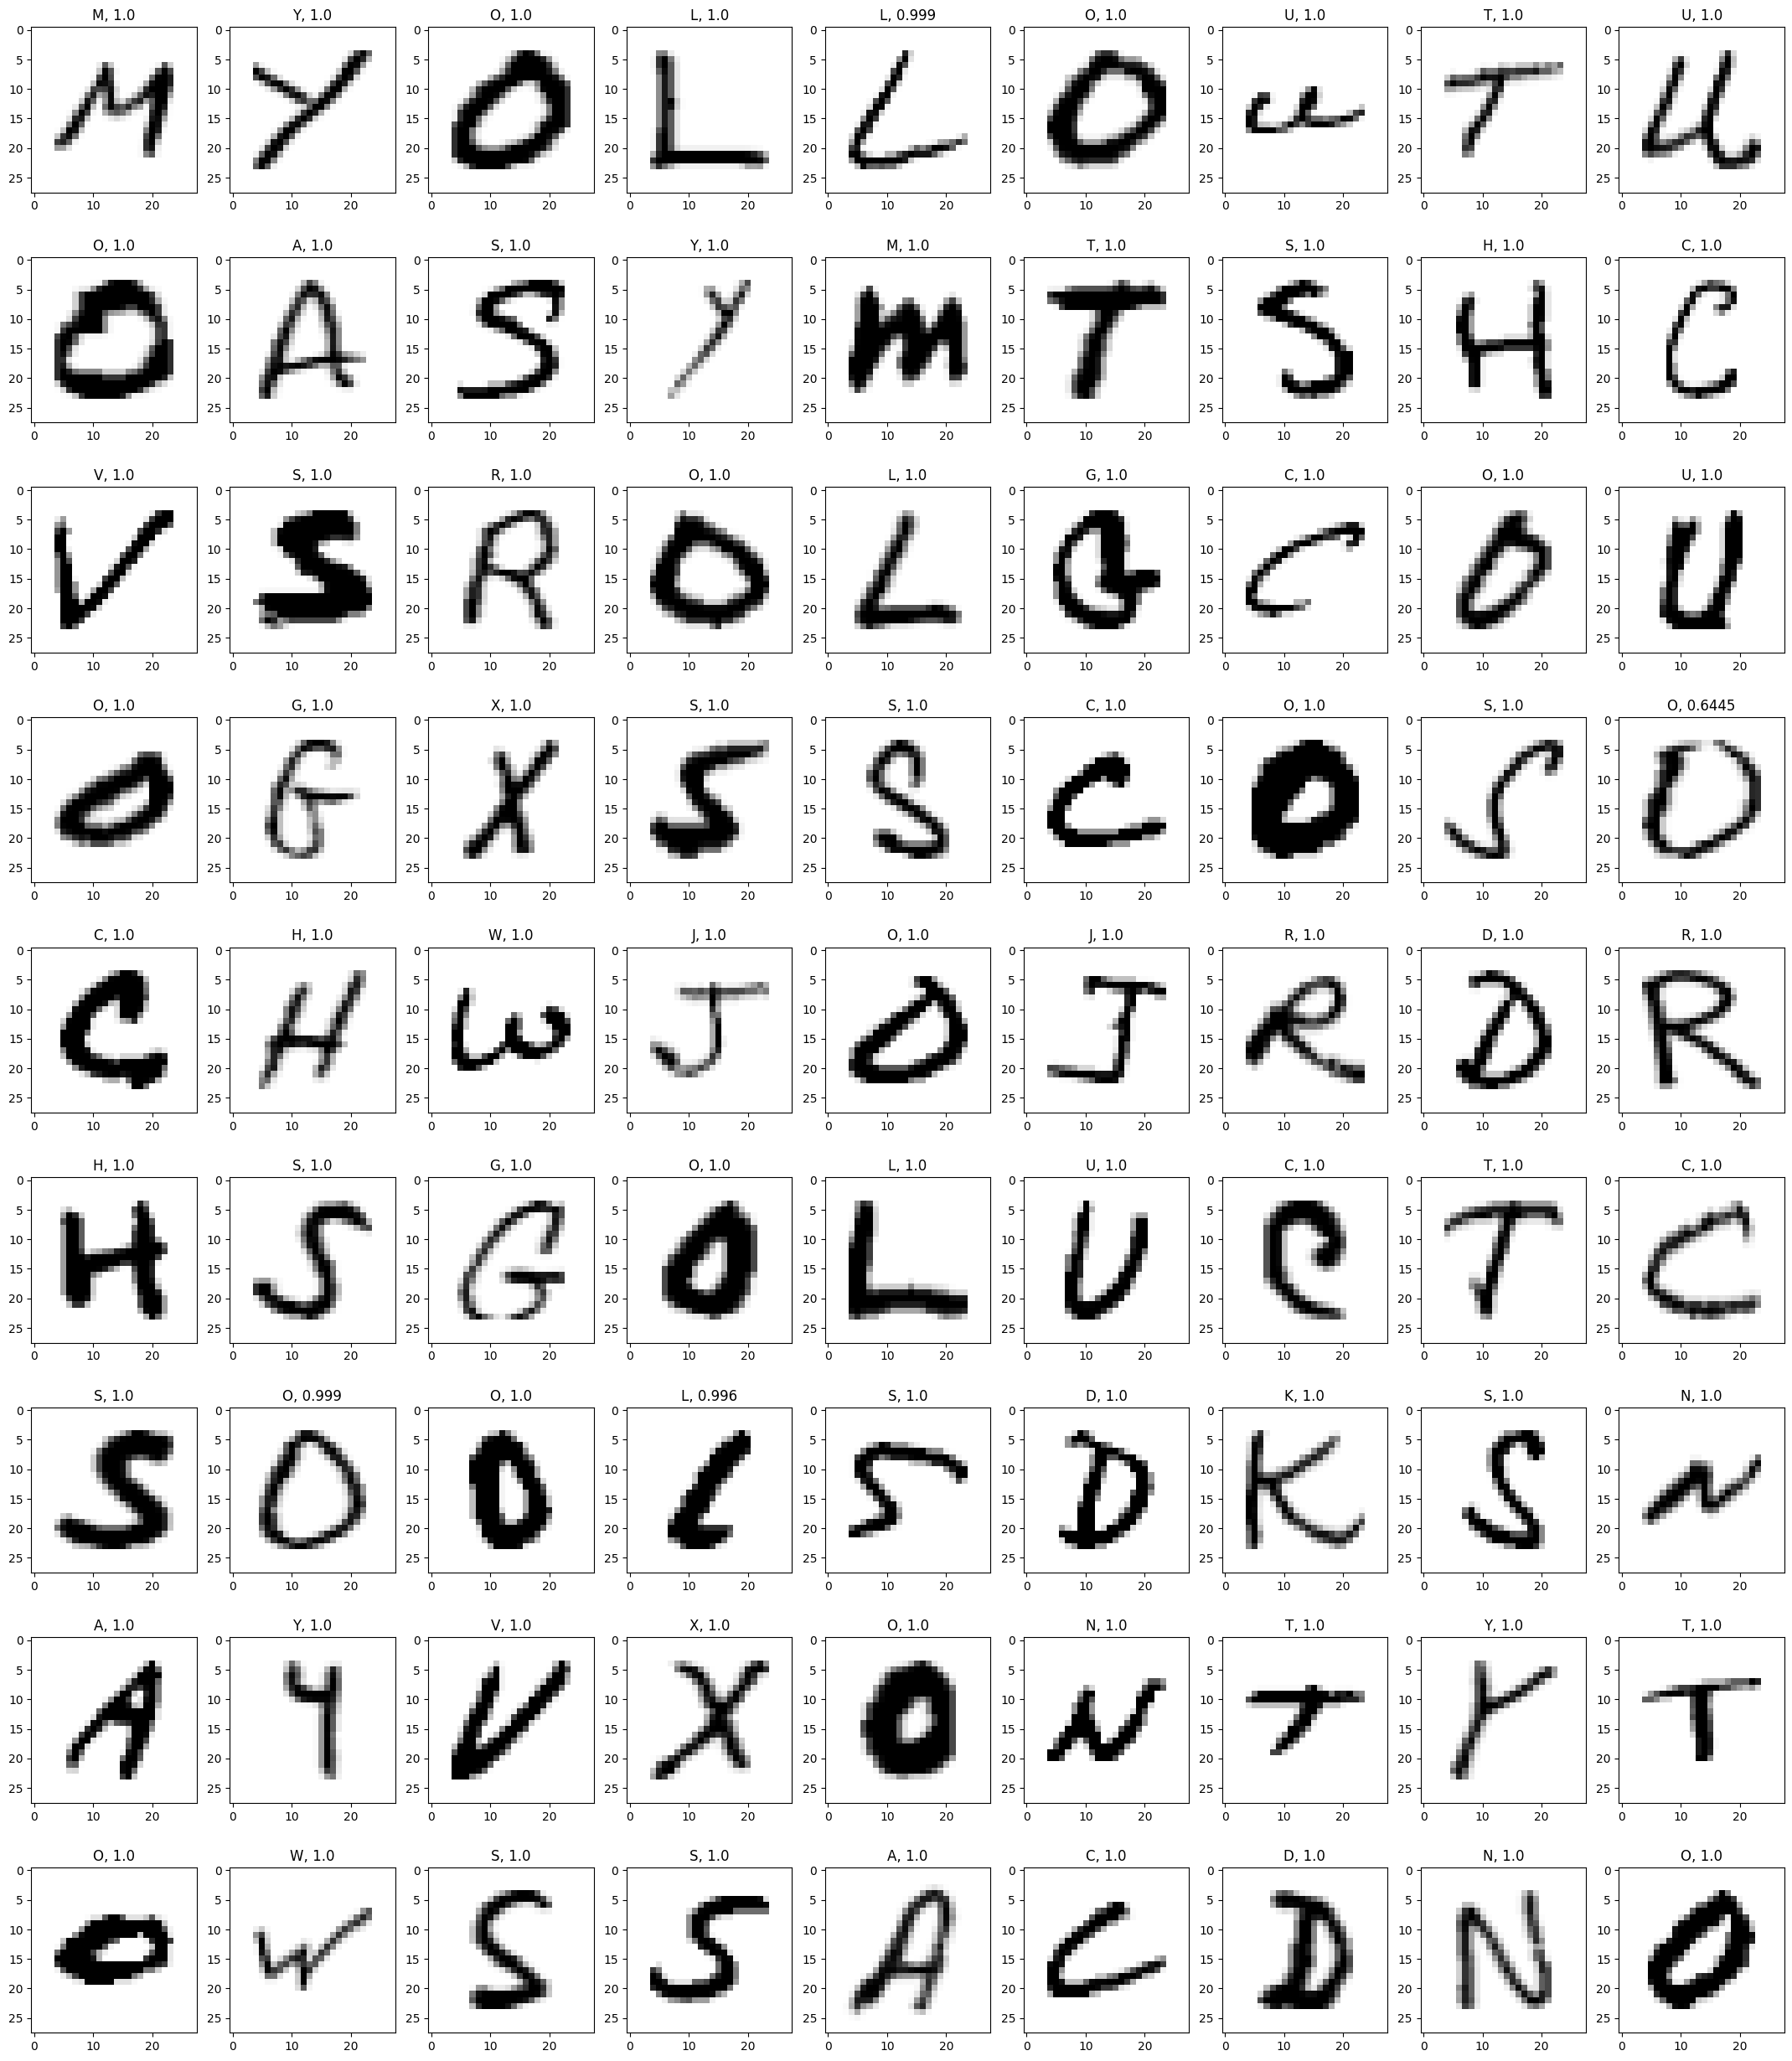

In [30]:
dim_x, dim_y = (9, 9)
wrong_index = []
pred = model.predict(critic_data[:dim_x * dim_y])

fig, axes = plt.subplots(dim_y, dim_x, figsize = (3 * dim_x, 3.5 * dim_y))
axes = axes.flatten()
for i,ax in enumerate(axes):
    img = np.reshape(data[critic_data_index[i]], (28,28))
    ax.imshow(img, cmap="Greys")

    pred_index = np.argmax(pred[i])
    accuracy = pred[i, pred_index]
    pred_letter = word_dict[pred_index]
    title = pred_letter + ", "
    if pred_index != data_label[critic_data_index[i]]:
        wrong_index.append(critic_data_index[i])
        title = title + f"{accuracy:.4f}" + " [" + word_dict[data_label[critic_data_index[i]]] + "]"
        ax.set_title(title, color='red')
    else:
        title = title + str(accuracy)
        ax.set_title(title)
    #ax.grid()

print(str(len(wrong_index)) + " wrong predicitons out of " + str(dim_x * dim_y))

In [21]:
pred = model.predict(critic_data)
wrong_index = []

for i, _ in enumerate(critic_data):
    pred_index = np.argmax(pred[i])
    accuracy = pred[i, pred_index]
    if pred_index != data_label[critic_data_index[i]]:
        wrong_index.append(critic_data_index[i])

wrong_index_len = len(wrong_index)
critic_data_len = len(critic_data)
print(str(wrong_index_len) + " wrong predicitons out of " + str(critic_data_len) + " (" + f"{wrong_index_len / critic_data_len * 100:.4f} %):")
print(*wrong_index, sep=", ")

101/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-08-18 10:04:36.987828: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_106', 4 bytes spill stores, 4 bytes spill loads



121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
25 wrong predicitons out of 3847 (0.6499 %):
340363, 316106, 132461, 334142, 249329, 219954, 223849, 367742, 168365, 26885, 90635, 372198, 13713, 159205, 311813, 308627, 61470, 22092, 310231, 363317, 360567, 360599, 67324, 36372, 5215


## Canvas [tkinter]

In [ ]:
letter_img = None

class Sketchpad(Canvas):
    def __init__(self, parent, **kwargs):
        super().__init__(parent, **kwargs)
        self.bind("<Button-1>", self.save_posn)
        self.bind("<B1-Motion>", self.add_line)
        
    def save_posn(self, event):
        self.lastx, self.lasty = event.x, event.y

    def add_line(self, event):
        self.create_oval((self.lastx, self.lasty, event.x, event.y), width=35, fill='black')
        self.save_posn(event)


def get_canvas_grayscale_array(sketch, size=(28, 28)):
    root.update()
    x = sketch.winfo_rootx()
    y = sketch.winfo_rooty()
    x1 = x + sketch.winfo_width()
    y1 = y + sketch.winfo_height()

    img = ImageGrab.grab(bbox=(x, y, x1, y1))
    img = img.convert('L')  # grayscale
    img = img.resize(size, Image.BILINEAR)

    arr = np.array(img)
    
    return 255.0 - arr

def predict(arr):
    pred = model.predict(arr)
    pred_index = np.argmax(pred[0])
    accuracy = pred[0, pred_index]
    pred_letter = word_dict[pred_index]
    label["text"] = pred_letter + ", " + str(accuracy)

root = Tk()
root.resizable(False, False)

sketch = Sketchpad(root, width=512, height=512, bg='white')
sketch.grid(row=0, column=0, columnspan=2, sticky=(N, W, E, S))

def get_letter():
    global letter_img
    letter_img = get_canvas_grayscale_array(sketch)
    predict(np.reshape(letter_img, (1,28,28,1)))
    #root.destroy()

def clear_canvas():
    sketch.delete("all")

submit_btn = Button(root, text="Submit", command=get_letter)
submit_btn.grid(row=2, column=0, sticky=(N, W, E, S))
clear_btn = Button(root, text="Clear", command=clear_canvas)
clear_btn.grid(row=2, column=1, sticky=(N, W, E, S))
label = Label(root, text="")
label.grid(row=1, column=0, columnspan=2)

root.mainloop()

## Canvas [ipycanvas]

In [65]:
handwirtten_letters_list = []

In [59]:
letter_img = None

# Canvas 512x512 con sfondo bianco
sketch = Canvas(width=512, height=512, layout=widgets.Layout(width='512px', height='512px'), sync_image_data=True)
sketch.fill_style = 'white'
sketch.fill_rect(0, 0, sketch.width, sketch.height)

# Colore e spessore penna
sketch.stroke_style = 'black'
sketch.fill_style = 'black'
sketch.line_cap = 'round'
sketch.line_join = 'round'
sketch.line_width = 35

last_pos = [None, None]
mouse_down = False

def handle_mouse_down(x, y):
    global mouse_down, last_pos
    mouse_down = True
    last_pos[0], last_pos[1] = x, y

def handle_mouse_up(x, y):
    global mouse_down
    mouse_down = False

def handle_mouse_move(x, y):
    if not mouse_down:
        return
    if last_pos[0] is not None:
        sketch.begin_path()
        sketch.stroke_line(last_pos[0], last_pos[1], x, y)
    last_pos[0], last_pos[1] = x, y

sketch.on_mouse_down(handle_mouse_down)
sketch.on_mouse_up(handle_mouse_up)
sketch.on_mouse_move(handle_mouse_move)

def get_canvas_grayscale_array():
    img_data = sketch.get_image_data(0, 0, sketch.width, sketch.height)
    img = Image.fromarray(img_data.astype(np.uint8))
    img = img.convert('L')
    img = img.resize((28, 28), Image.BILINEAR)
    arr = np.array(img)
    return 255.0 - arr

def predict_letter(_):
    global letter_img
    letter_img = get_canvas_grayscale_array()
    arr_reshaped = np.reshape(letter_img, (1, 28, 28, 1))
    pred = model.predict(arr_reshaped)
    pred_index = np.argmax(pred[0])
    accuracy = pred[0, pred_index]
    pred_letter = word_dict[pred_index]
    output_label.value = f"{pred_letter}, {accuracy}"

def clear_canvas(_):
    sketch.clear()
    sketch.fill_style = 'white'
    sketch.fill_rect(0, 0, sketch.width, sketch.height)
    sketch.stroke_style = 'black'
    sketch.fill_style = 'black'

def save_to_list(_):
    global handwirtten_letters_list
    img_to_save = get_canvas_grayscale_array().reshape((1, 28, 28, 1))
    handwirtten_letters_list.append(img_to_save)
    

submit_btn = widgets.Button(description="Submit")
submit_btn.on_click(predict_letter)

clear_btn = widgets.Button(description="Clear")
clear_btn.on_click(clear_canvas)

save_btn = widgets.Button(description="Add to list")
save_btn.on_click(save_to_list)

output_label = widgets.Label(value="")
widgets.VBox([sketch, widgets.HBox([submit_btn, save_btn, clear_btn]), output_label])

## Visualizzazione degli step intermedi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


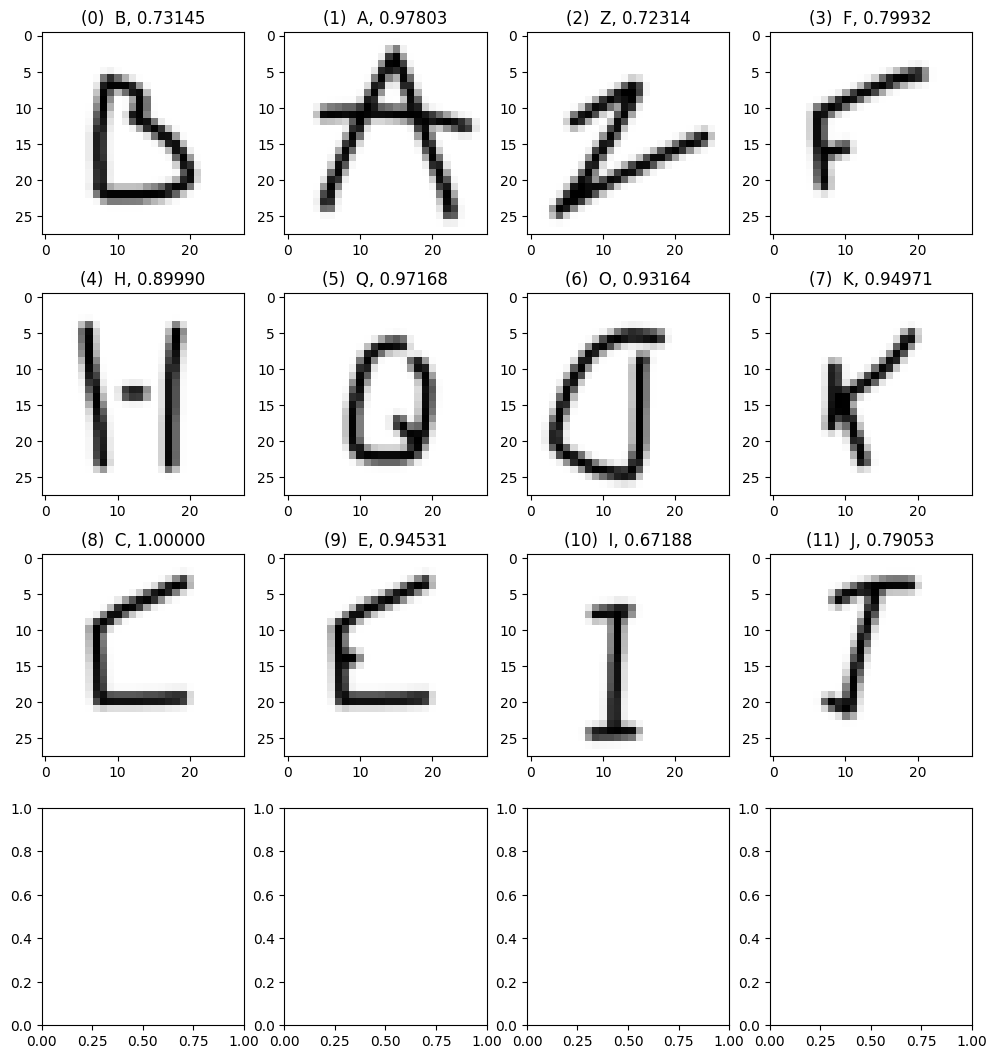

In [162]:
dim_k = int(np.ceil(np.sqrt(len(handwirtten_letters_list))))
fig, axes = plt.subplots(dim_k, dim_k, figsize = (3 * dim_k, 3.25 * dim_k))
#fig.suptitle(f"{pred_letter}, {model.layers[filter_idx].name} [{model.name}]")
axes = axes.flatten()
for i,ax in enumerate(axes):
    if i < len(handwirtten_letters_list):
        l = handwirtten_letters_list[i]
        pred = model.predict(l)
        pred_index = np.argmax(pred[0])
        accuracy = pred[0, pred_index]
        pred_letter = word_dict[pred_index]
        title = f"({i})  {pred_letter}, {accuracy:.5f}"
        ax.imshow(np.reshape(l, (28,28)), cmap="Greys")
        ax.set_title(title)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Text(0.5, 1.0, 'J, 0.7905')

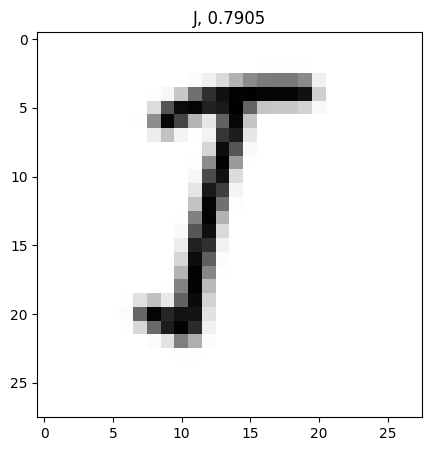

In [154]:
letter_to_predict = handwirtten_letters_list[11]
pred = model.predict(letter_to_predict)

pred_index = np.argmax(pred[0])
accuracy = pred[0, pred_index]
pred_letter = word_dict[pred_index]

title = pred_letter + ", " + str(accuracy)

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.imshow(np.reshape(letter_to_predict, (28,28)), cmap="Greys")
ax.set_title(title)
#plt.show()

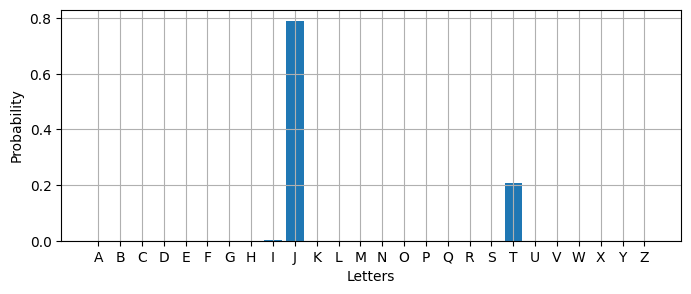

In [155]:
letters = np.array(list(word_dict.values()))
fig, ax = plt.subplots(1,1, figsize=(8,3))
ax.bar(letters, pred[0])
ax.set(xlabel="Letters", ylabel="Probability")
ax.grid()
plt.show()

In [140]:
sample_image = letter_to_predict

layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.inputs, outputs=layer_outputs)

activations = activation_model.predict(sample_image)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 28, 28, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


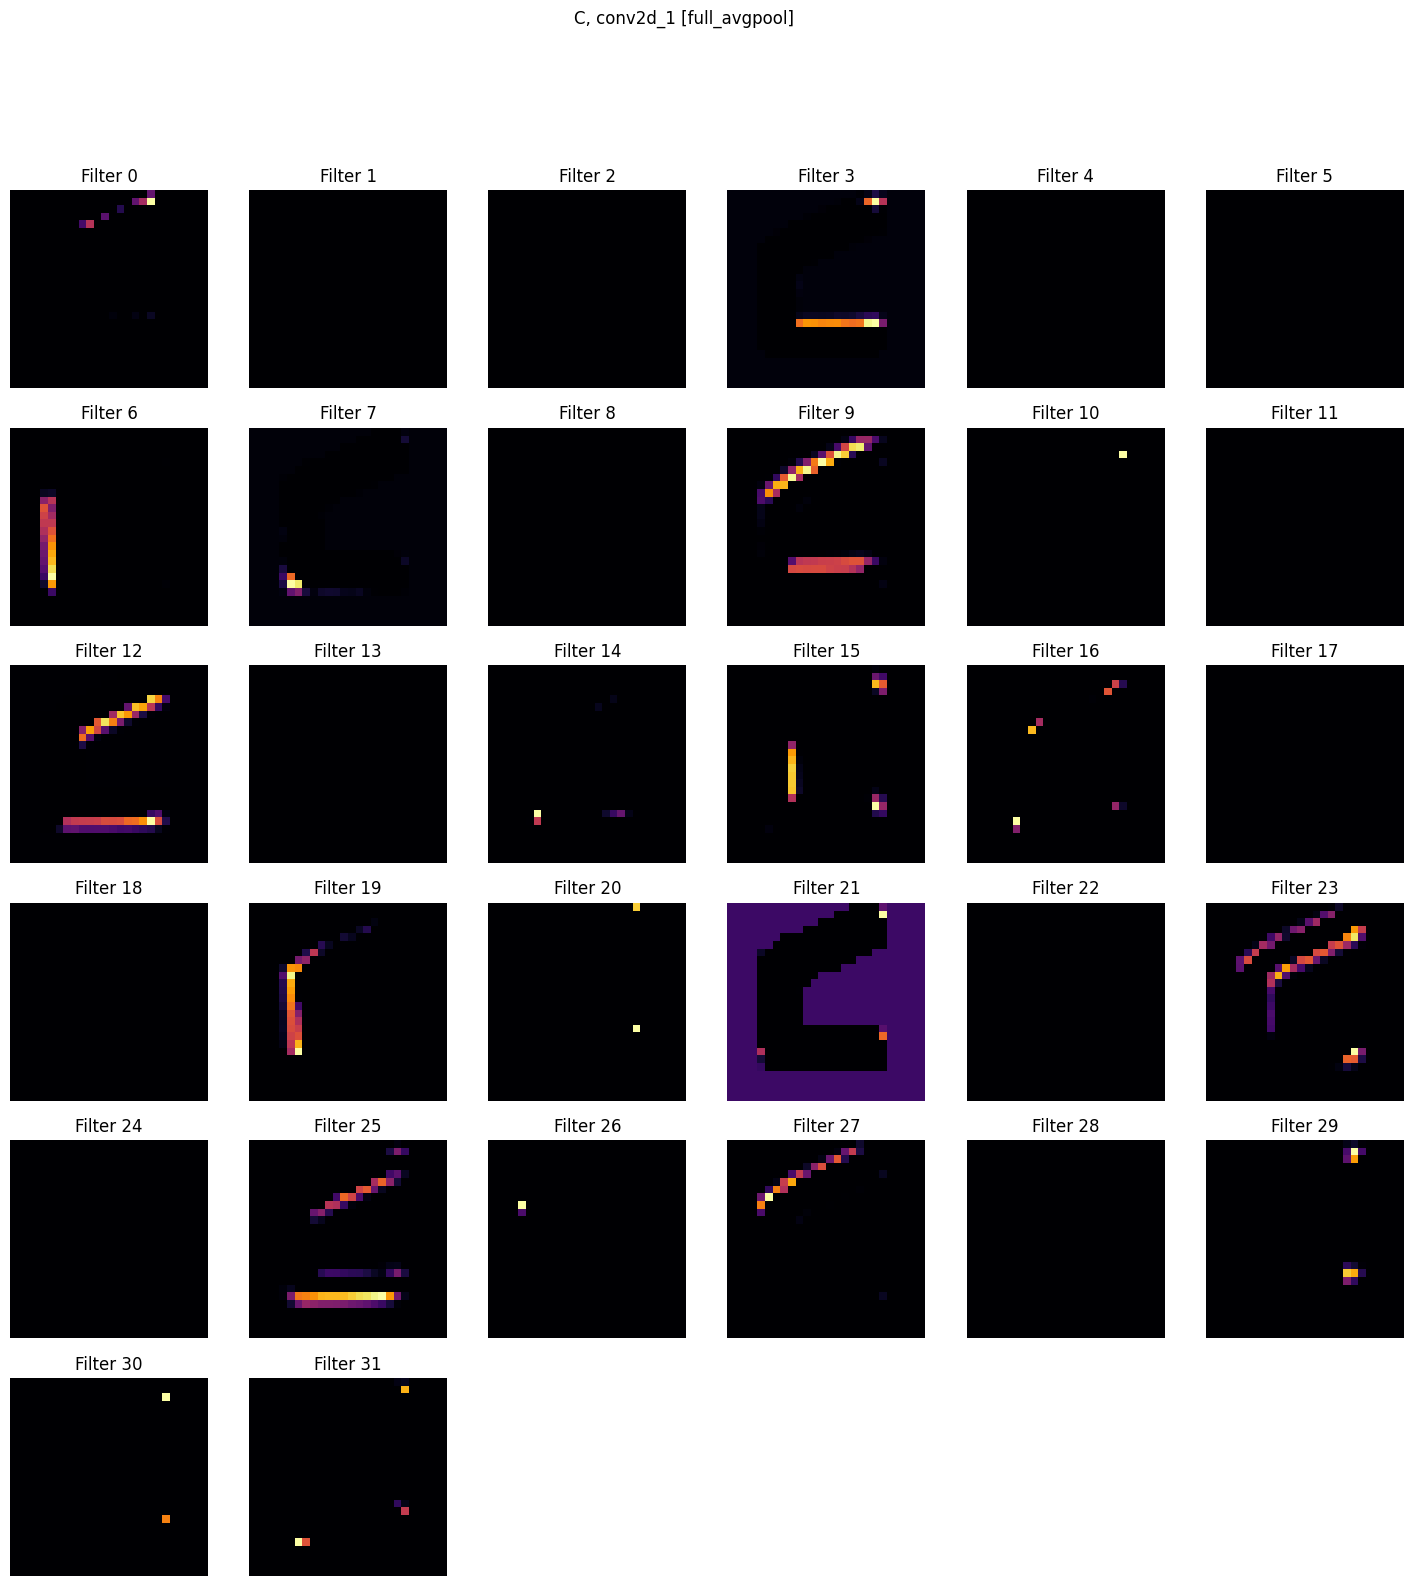

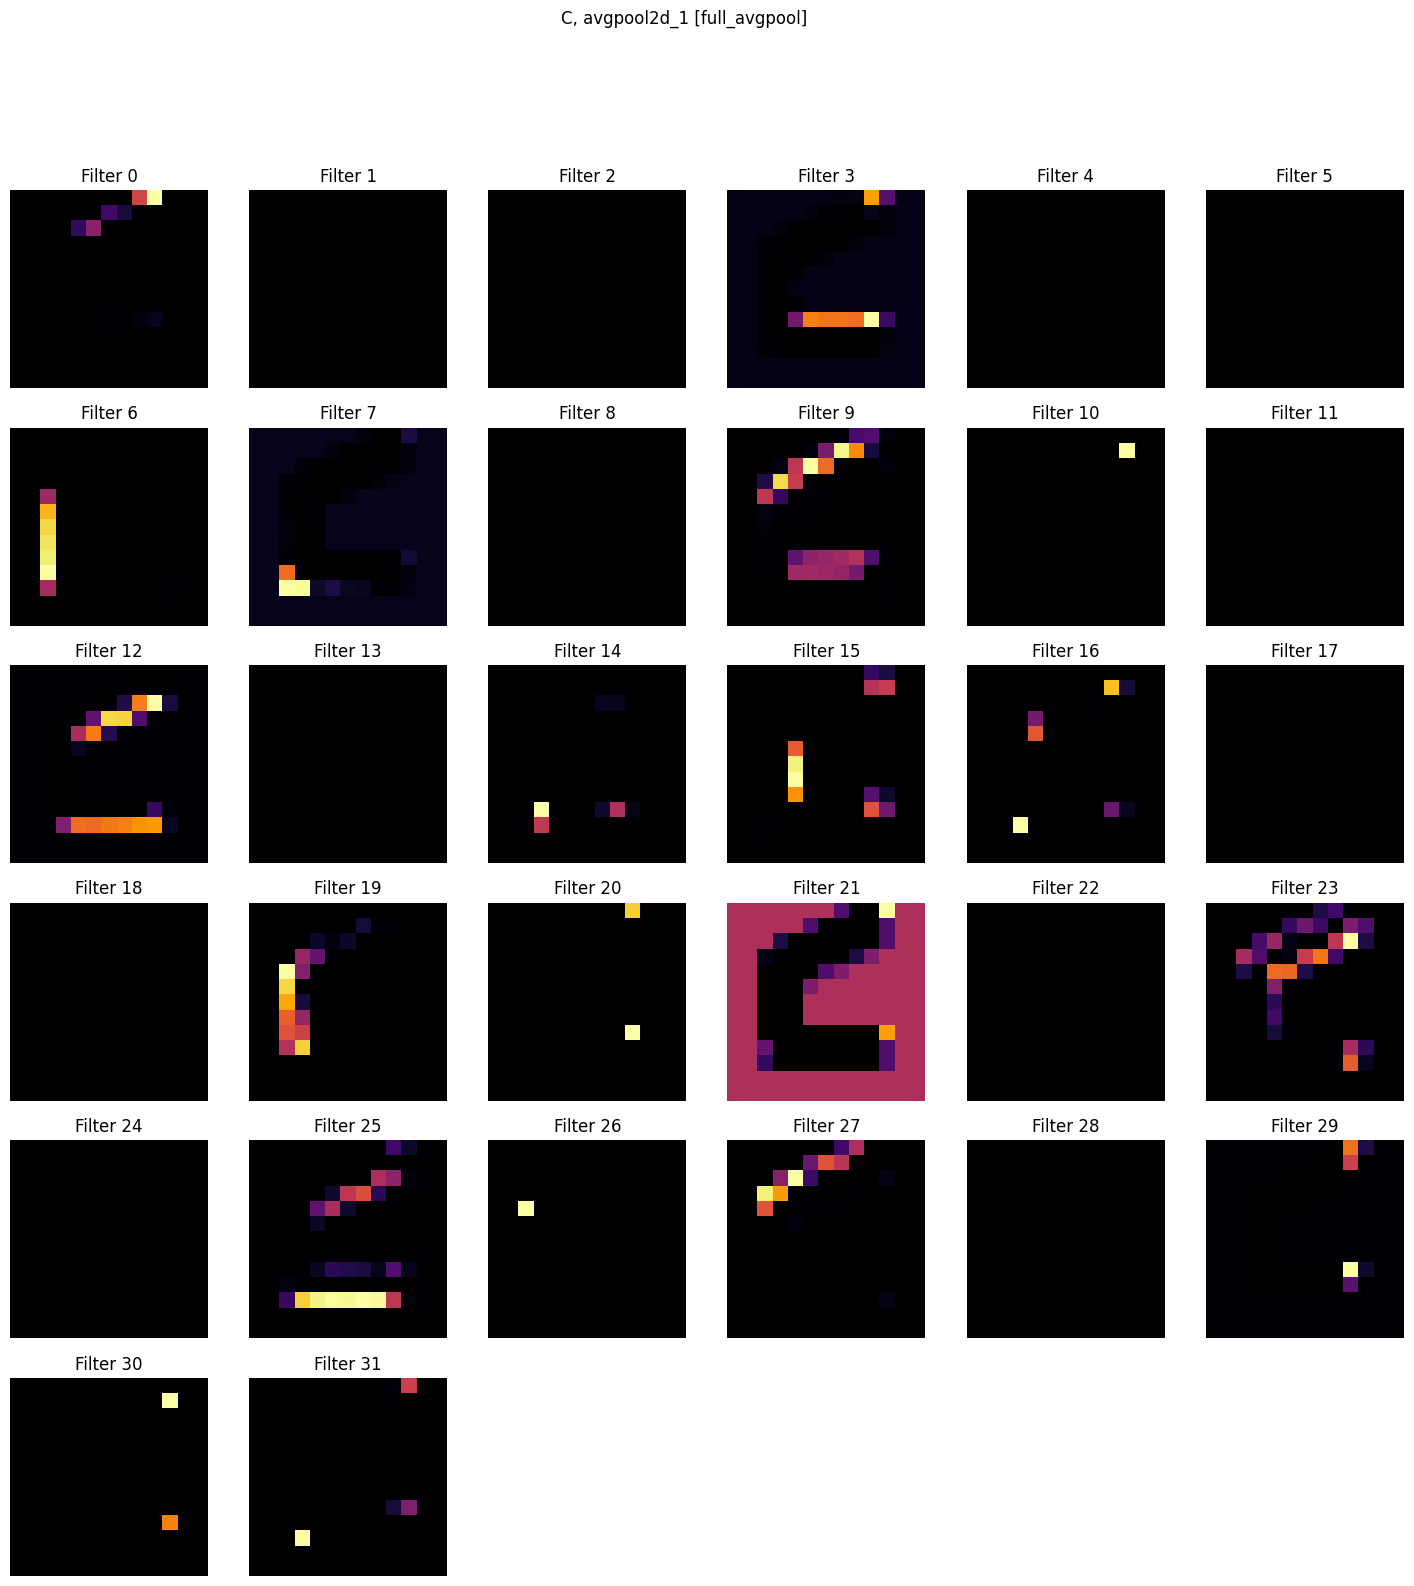

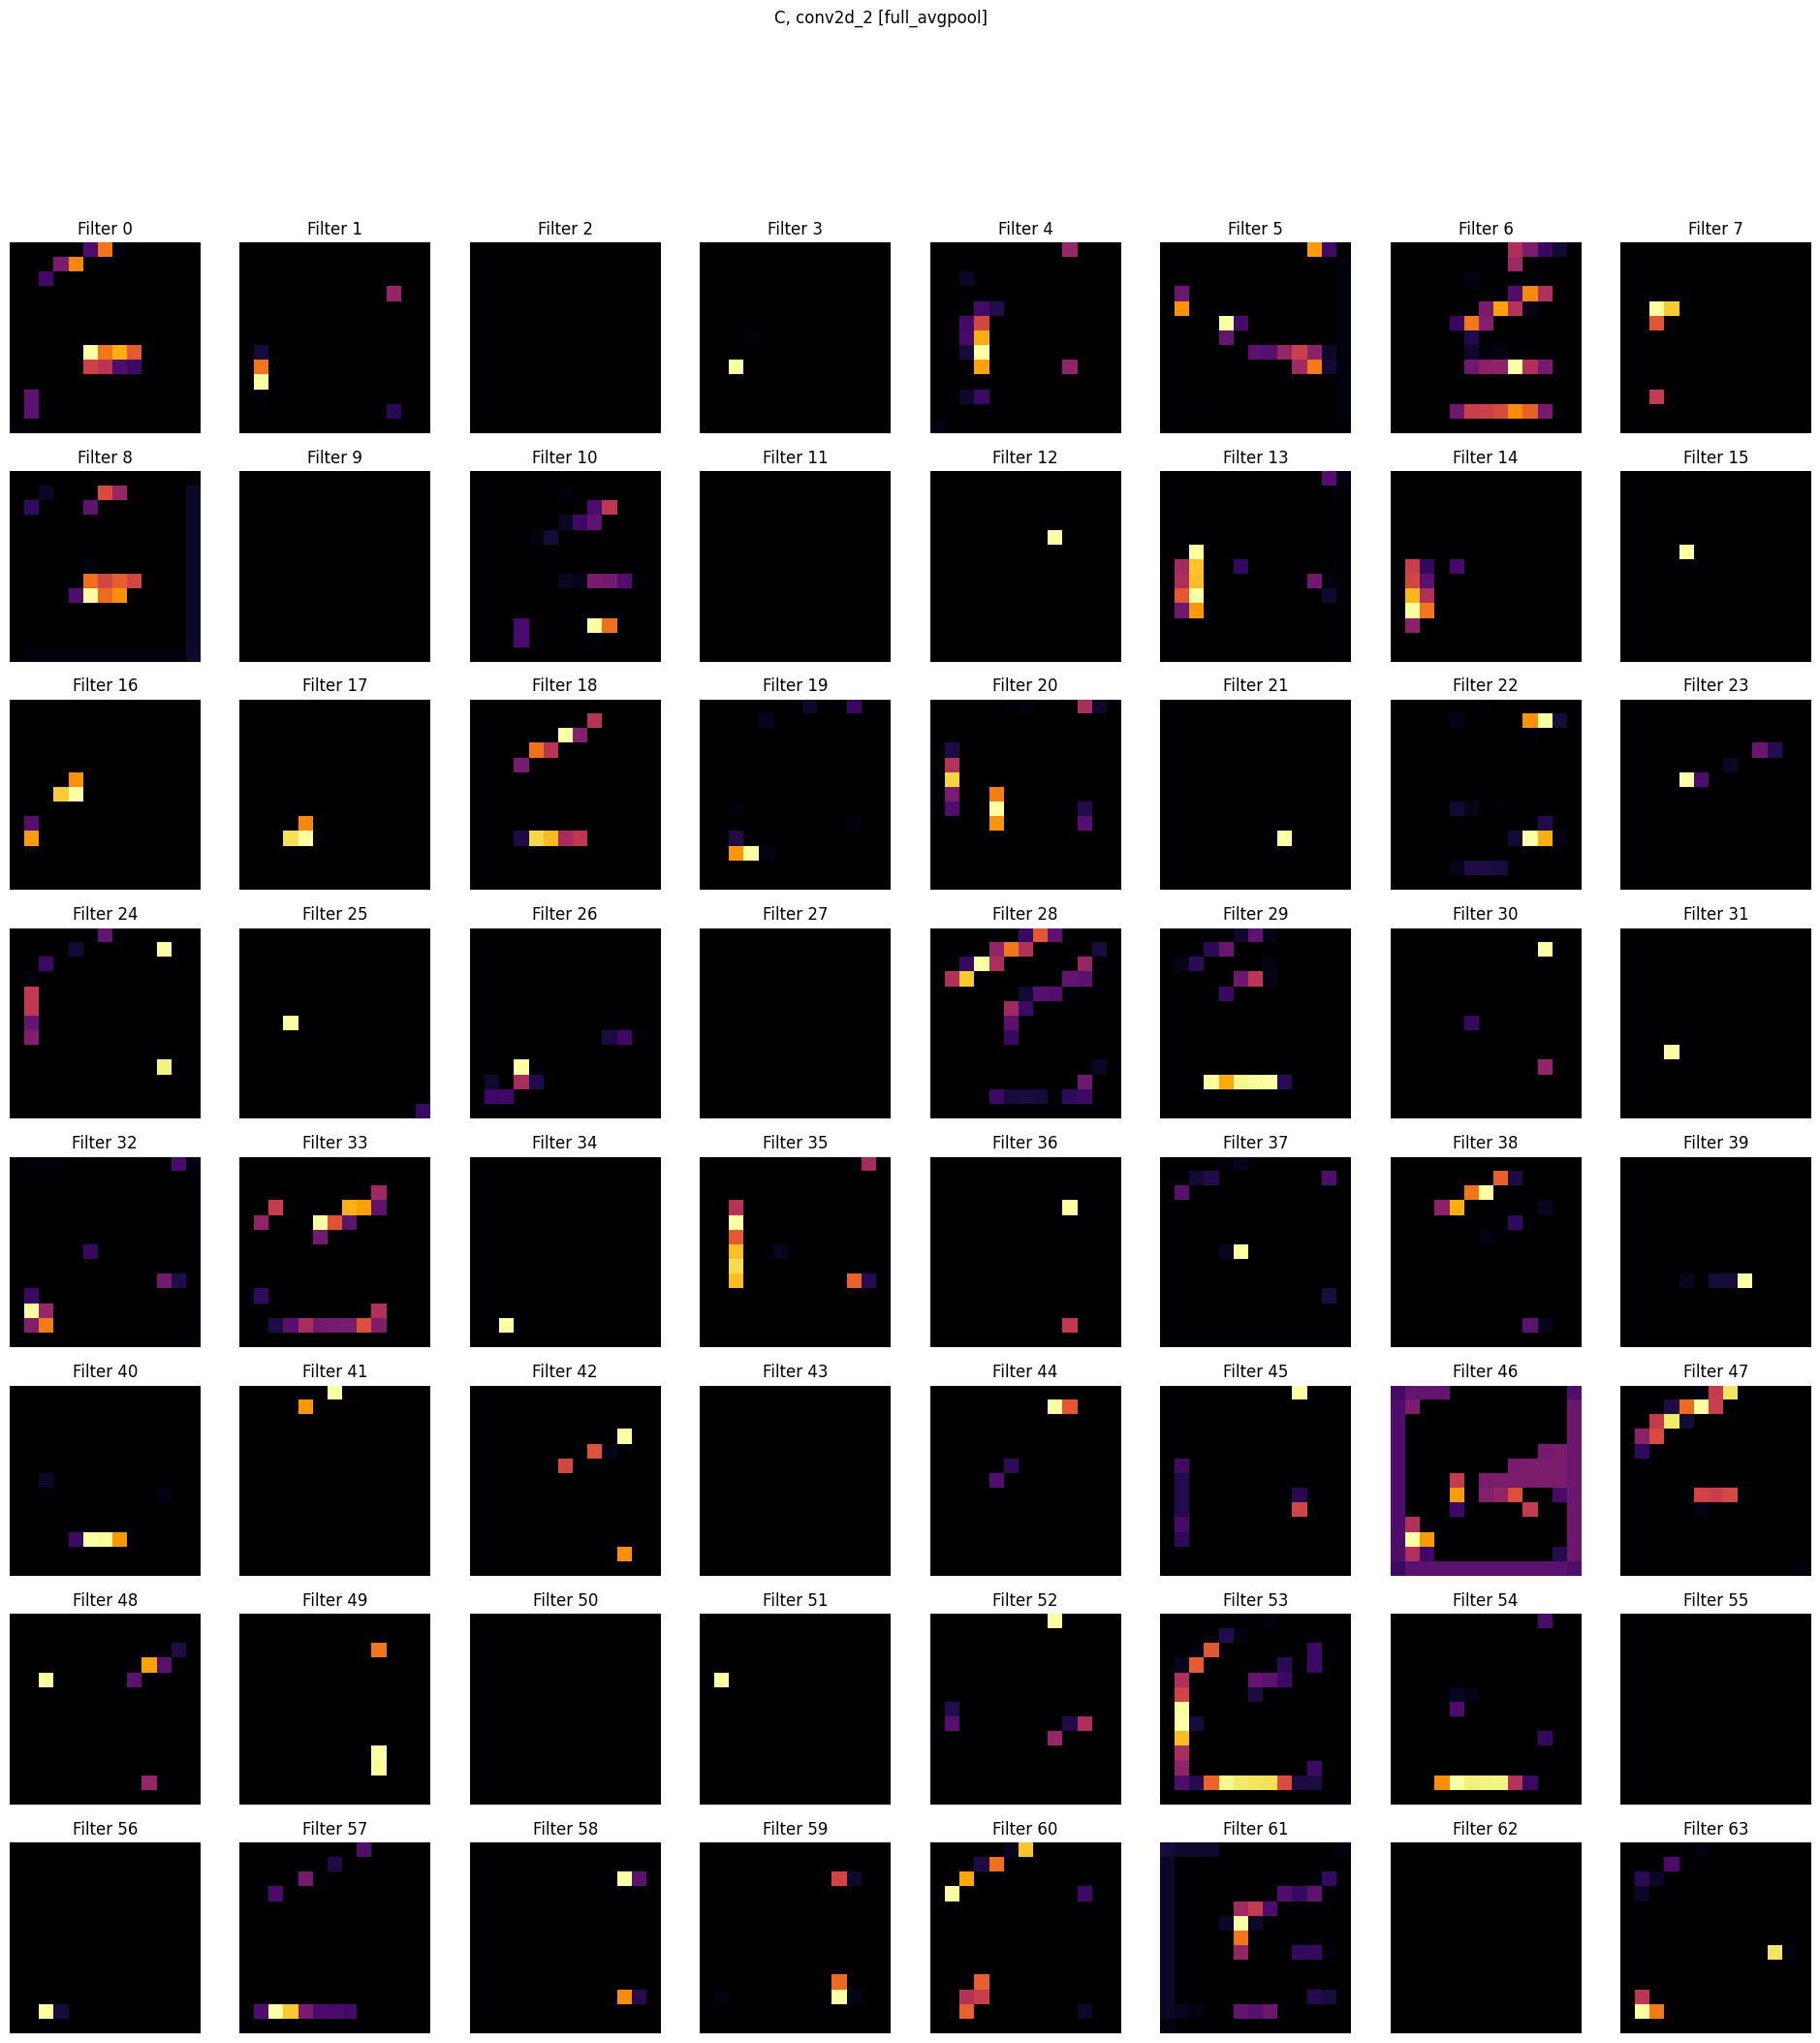

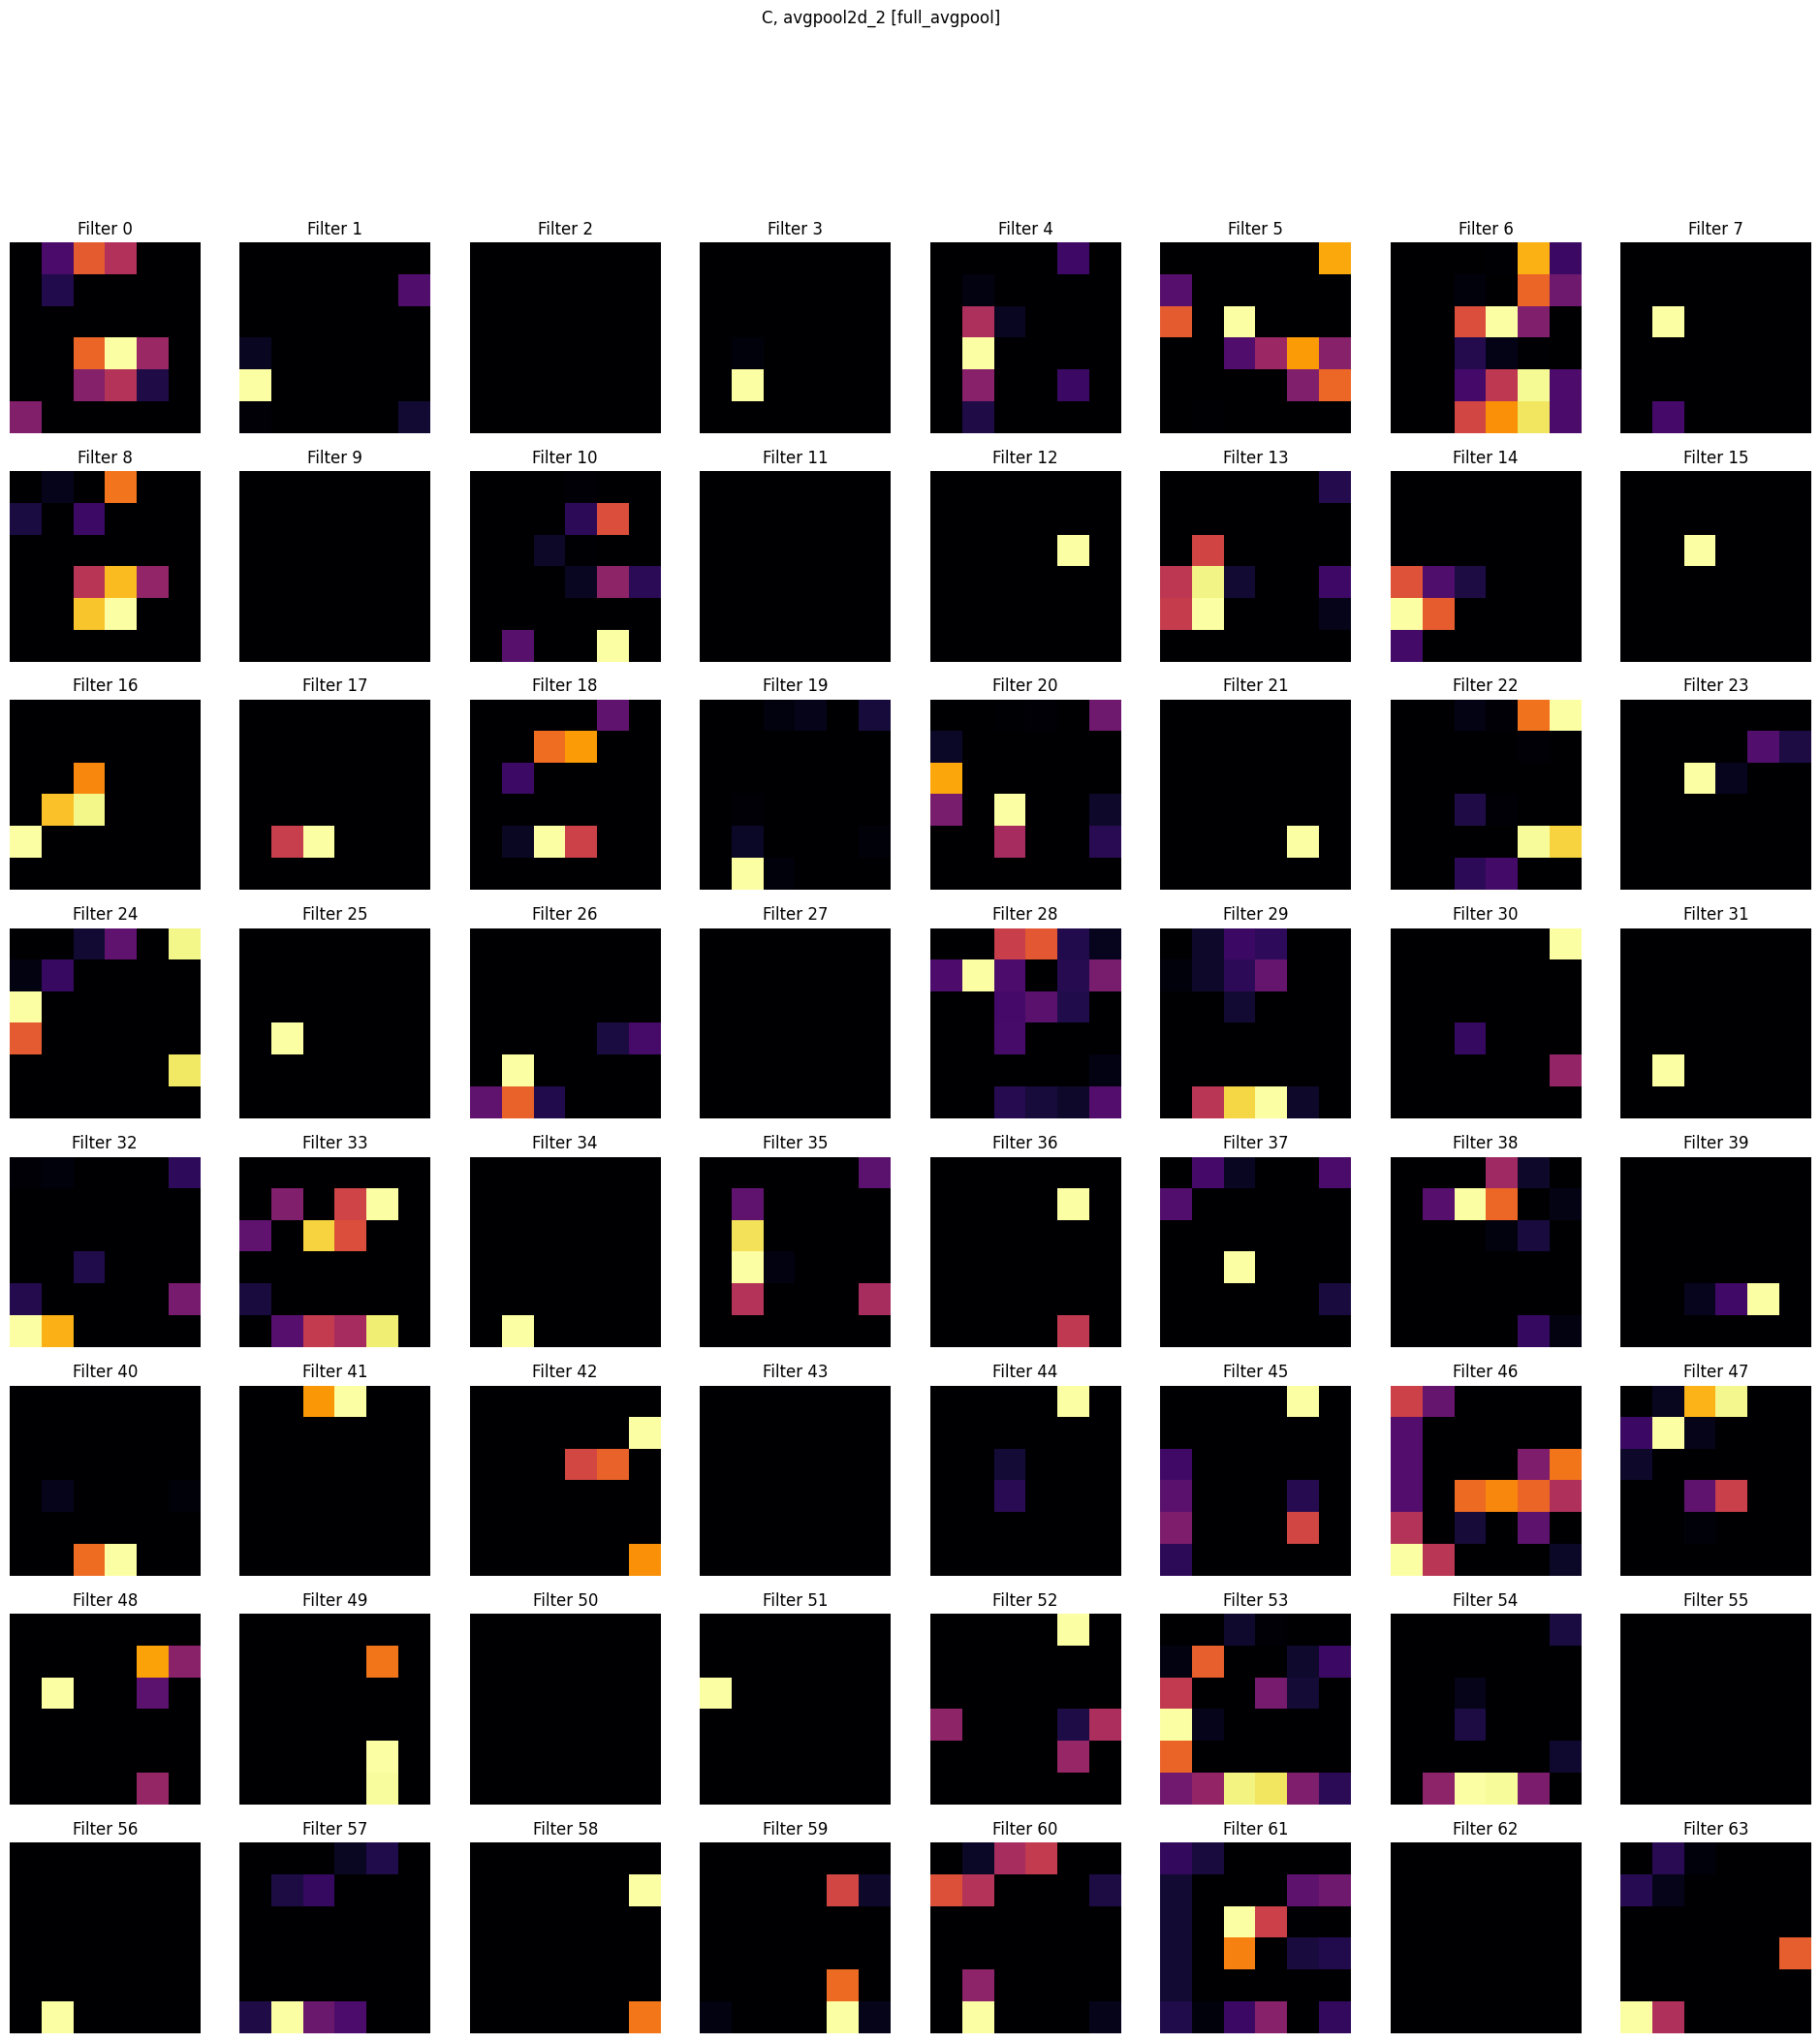

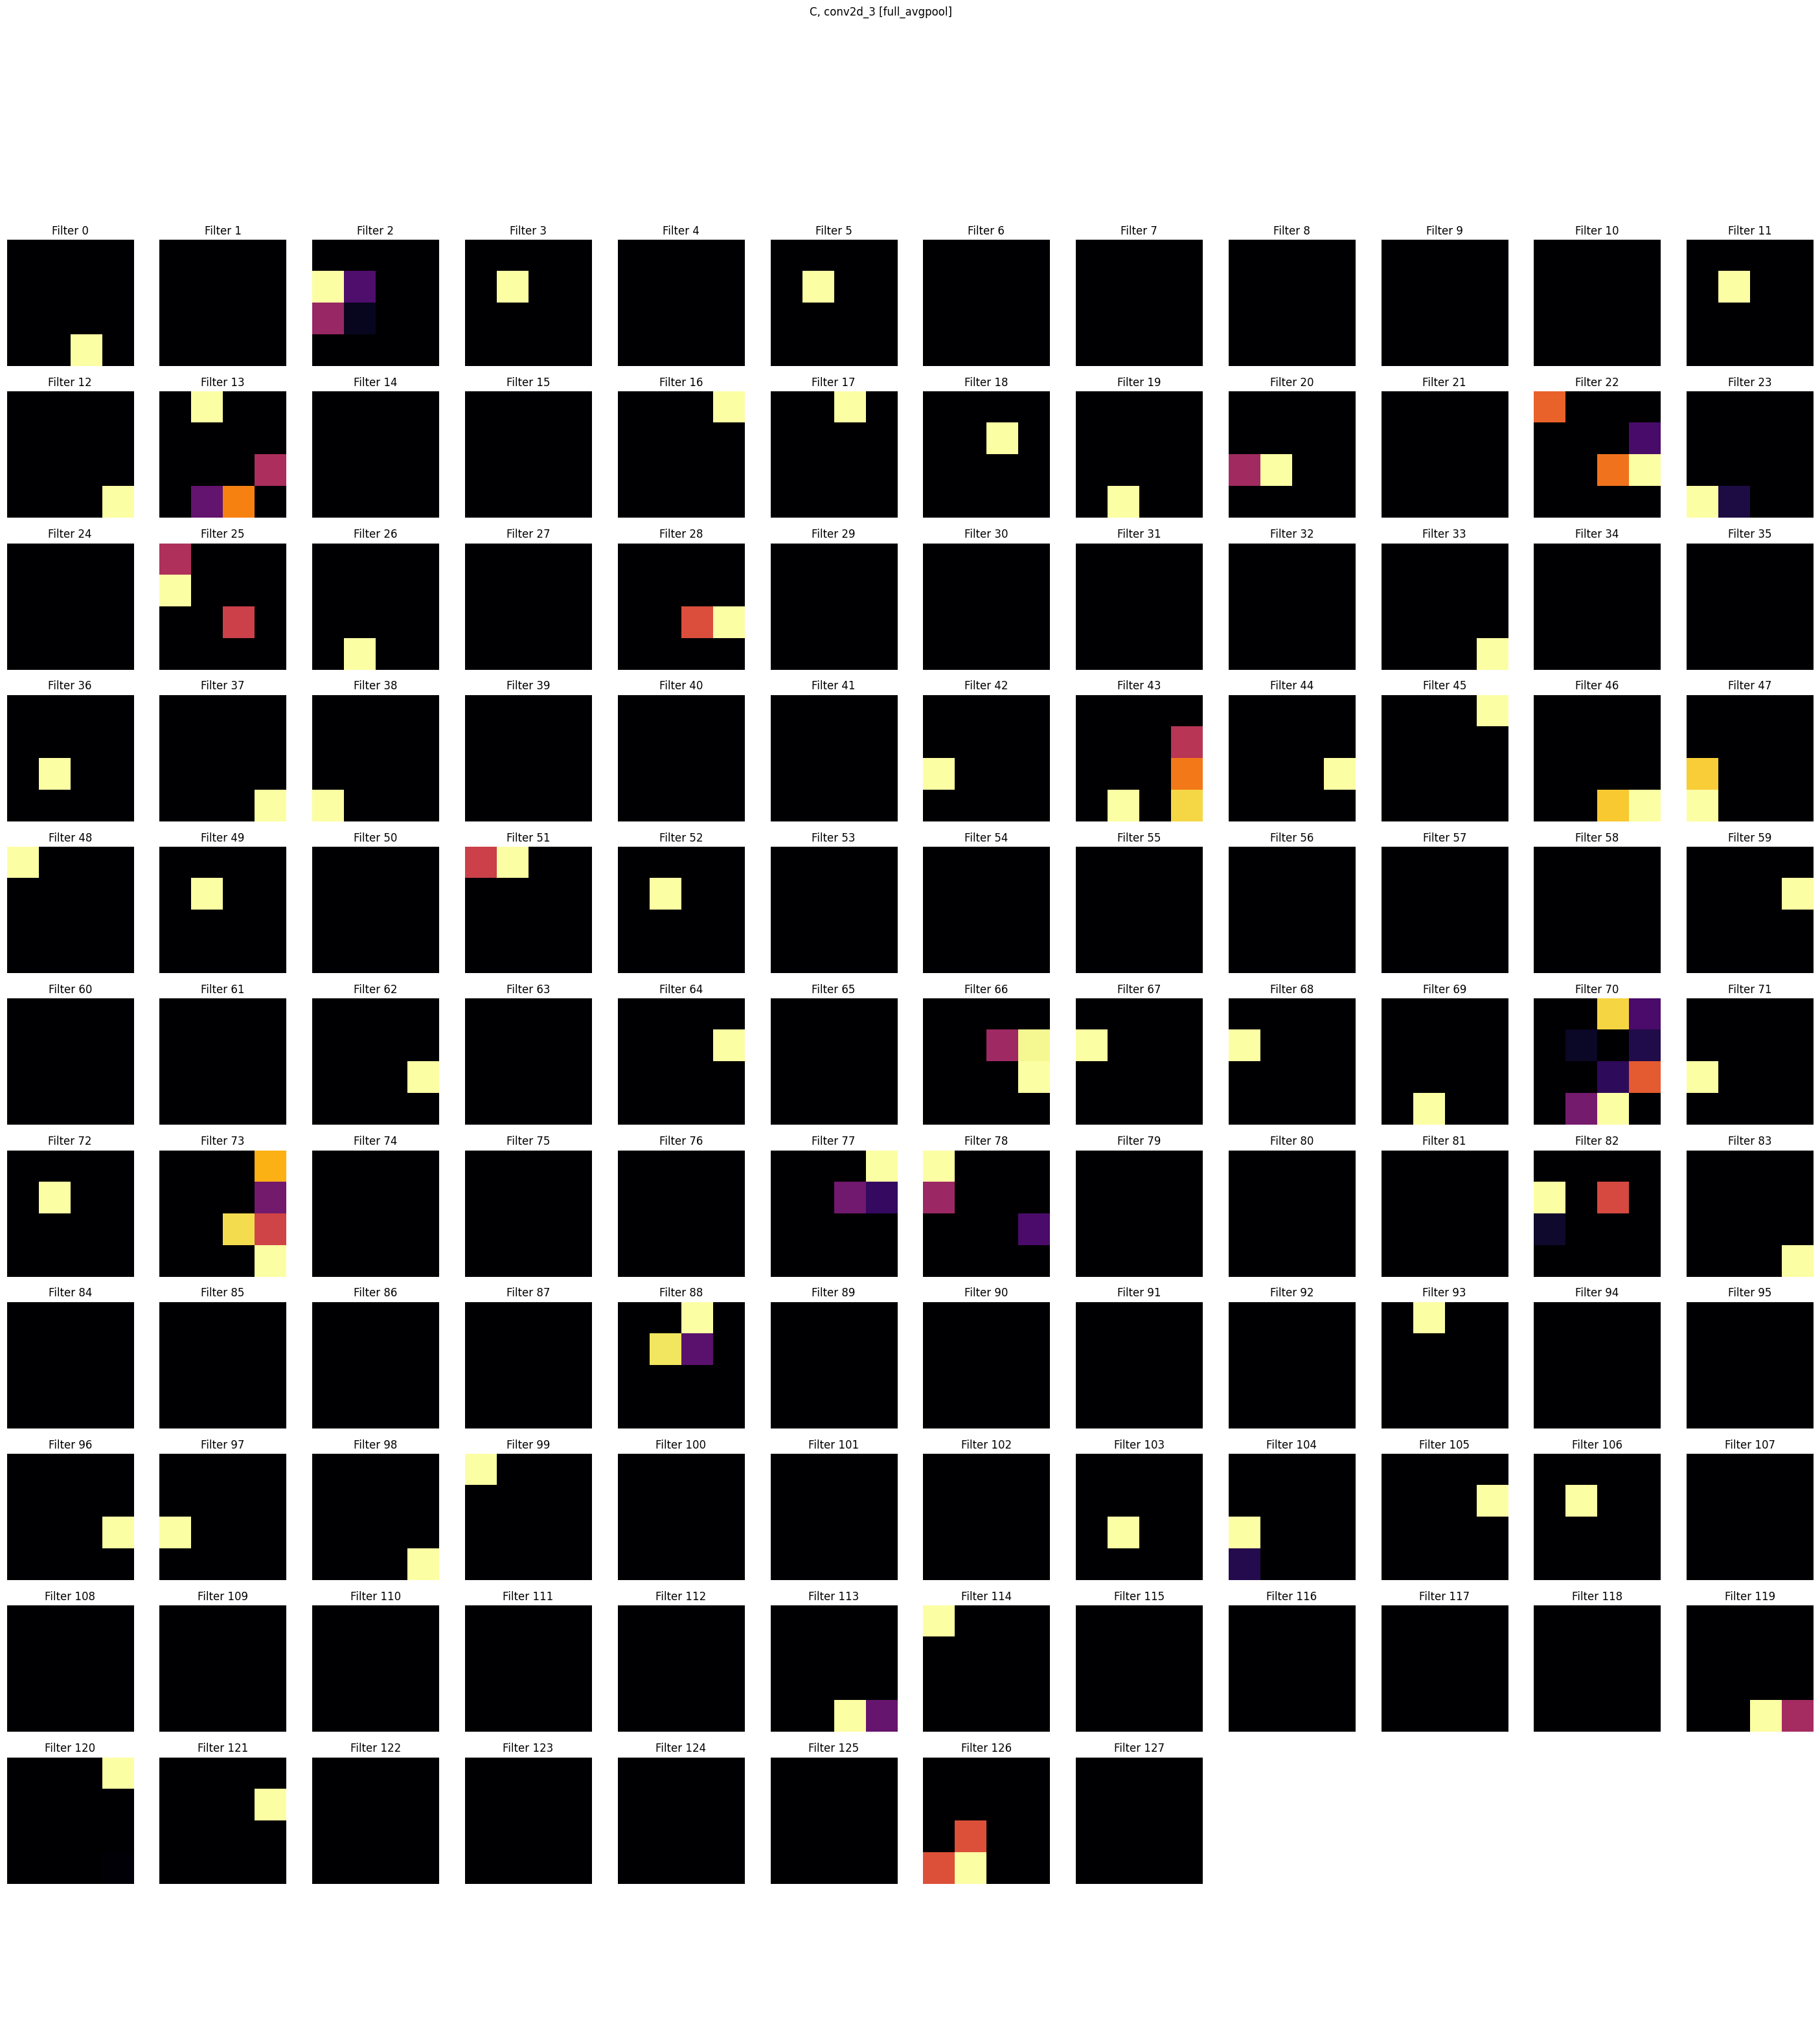

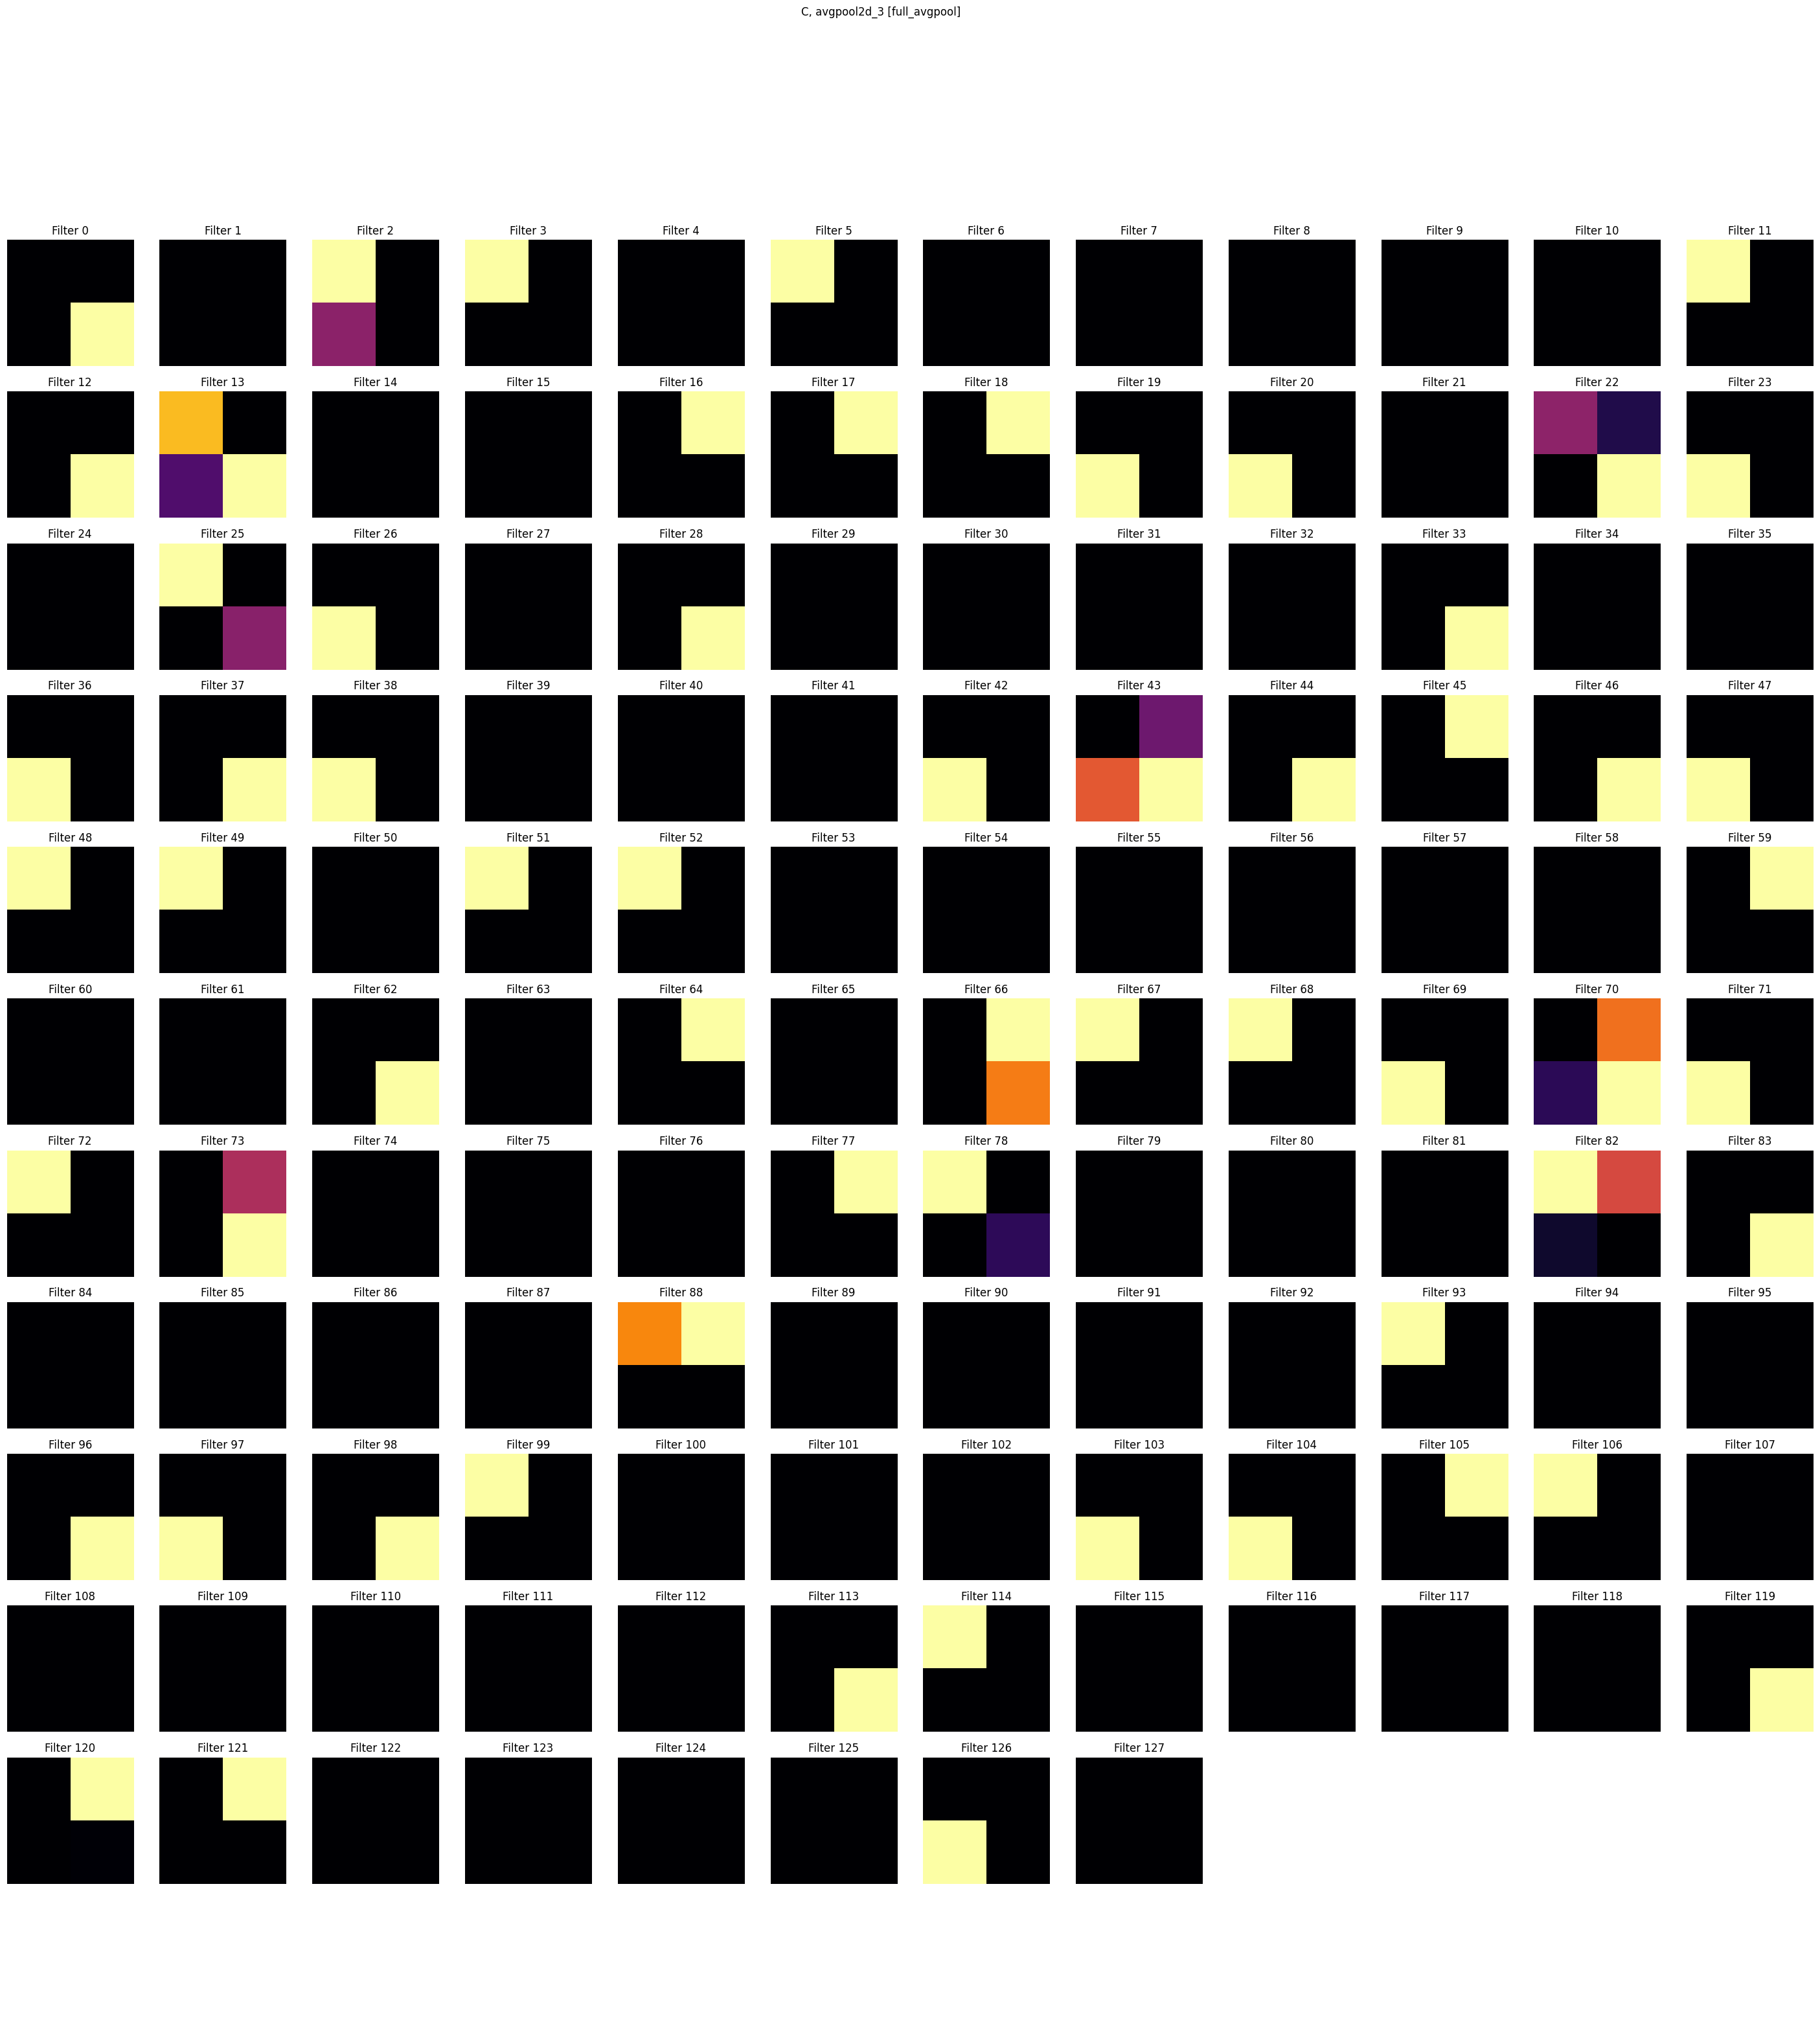

In [136]:
for filter_idx, act in enumerate(activations[:6]):
    num_filters = act.shape[-1]
    
    dim_k = int(np.ceil(np.sqrt(num_filters)))
    fig, axes = plt.subplots(dim_k, dim_k, figsize = (3 * dim_k, 3 * dim_k))
    fig.suptitle(f"{pred_letter}, {model.layers[filter_idx].name} [{model.name}]")
    axes = axes.flatten()
    for i,ax in enumerate(axes):
        if i < num_filters:
            img = act[0, :, :, i]
            ax.imshow(img, cmap="inferno")
            ax.set_title(f'Filter {i}')
        ax.axis('off')
    file_dir = f'plots/{pred_letter}'
    file_name = f'{pred_letter}_{model.name}_layer_{filter_idx}.png'
    full_path = os.path.join(file_dir, file_name)
    os.makedirs(file_dir, exist_ok=True)
    plt.savefig(full_path)

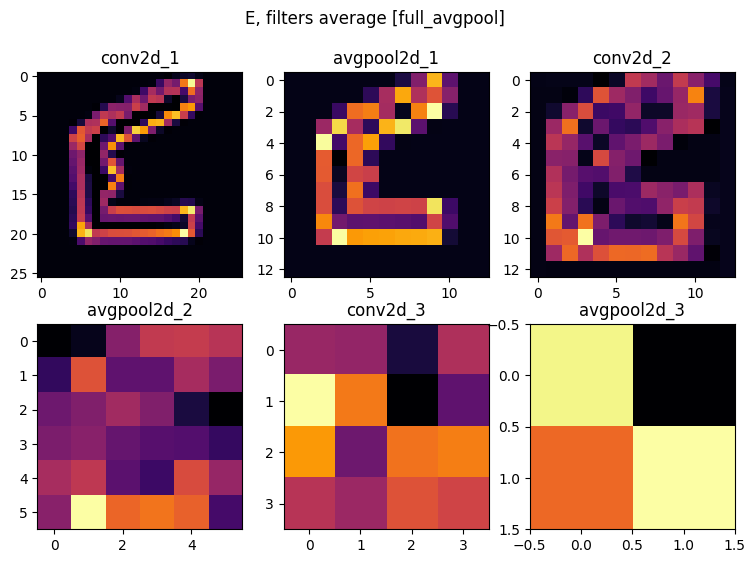

In [141]:
dim_x, dim_y = (3, 2)
fig, axes = plt.subplots(dim_y, dim_x, figsize = (3 * dim_x, 3 * dim_y))
fig.suptitle(f"{pred_letter}, filters average [{model.name}]")
axes = axes.flatten()
for i,act in enumerate(activations[:6]):
    ax = axes[i]
    num_filters = act.shape[-1]
    img = np.empty(shape=(act.shape[1],act.shape[2]))
    for x in range(act.shape[1]):
        for y in range(act.shape[2]):
            img[x,y] = np.average(act[0, x, y,:])
    
    ax.imshow(img, cmap="inferno")
    ax.set_title(f"{model.layers[i].name}")

file_dir = f'plots/{pred_letter}'
file_name = f'{pred_letter}_{model.name}_filters_avg.png'
full_path = os.path.join(file_dir, file_name)
os.makedirs(file_dir, exist_ok=True)
plt.savefig(full_path)